In [1]:
import datetime, calendar, glob, os

import pickle as pkl
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from skfda.representation.basis import Fourier, BSpline
from skfda.exploratory.depth import ModifiedBandDepth, IntegratedDepth
from skfda import FDataGrid

from matplotlib import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.transforms import ScaledTranslation

from scipy.integrate import quad
from scipy.stats import multivariate_normal, norm

from sklearn.neighbors import KernelDensity

from statsmodels.distributions.empirical_distribution import ECDF

from functional_utils import (_fDepth, 
                              _fQuantile, 
                              _bootstrap_fDepth,
                              _bootrapped_confidence_intervals_from_fDepth,
                              _confidence_intervals_from_fDepth, 
                              _confidence_intervals_from_eCDF)

from loading_utils import (_process_wind_metadata,
                           _process_testing_curves,
                           _process_testing_forecasts,
                           _process_training_curves,
                           _process_traning_forecasts)

from scores_utils import *

plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handleheight"] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_fDepth = "/Users/Guille/Desktop/dynamic_update/functional_forecast_dynamic_update/fDepth"
path_to_data   = "/Users/Guille/Desktop/dynamic_update/data"
path_to_images = "/Users/Guille/Desktop/dynamic_update/images"

# Loading color palette
palette_ = pd.read_csv(path_to_data + "/palette.csv")

# Loading Texas map
TX_ = gpd.read_file(path_to_data + "/maps/TX/State.shp")

# Historical random curves and day-ahead forecasts

In [2]:
T = 288
resource = 'wind'

# Load 2017 data as training set
with open(path_to_data + f"/linear_preprocessed_{resource}_2017.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_tr_ = _data["assets"]
F_tr_      = _data["observations"]
E_tr_      = _data["forecasts"]
print(assets_tr_.shape, F_tr_.shape, E_tr_.shape)

# Reshape to day x interval x asset format
F_tr_ = F_tr_.reshape(int(F_tr_.shape[0]/T), T, F_tr_.shape[1])
E_tr_ = E_tr_.reshape(int(E_tr_.shape[0]/T), T, E_tr_.shape[1])
print(F_tr_.shape, E_tr_.shape)

# Load 2018 data as testing set
with open(path_to_data + f"/linear_preprocessed_{resource}_2018.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_ts_ = _data["assets"]
F_ts_      = _data["observations"]
E_ts_      = _data["forecasts"]
print(assets_ts_.shape, F_ts_.shape, E_ts_.shape)

# Reshape to day x interval x asset format
F_ts_ = F_ts_.reshape(int(F_ts_.shape[0]/T), T, F_ts_.shape[1])
E_ts_ = E_ts_.reshape(int(E_ts_.shape[0]/T), T, E_ts_.shape[1])
print(F_ts_.shape, E_ts_.shape)

# Short testing set with training set order
order  = {v: i for i, v in enumerate(assets_tr_)}
idx_   = np.argsort([order[x] for x in assets_ts_])
F_ts_  = F_ts_[:, :, idx_]
E_ts_  = E_ts_[:, :, idx_]
print(F_ts_.shape, E_ts_.shape)

# From generation to capacity factor
p_tr_ = np.max(np.max(F_tr_, axis = 0), axis = 0)
p_ts_ = np.max(np.max(F_ts_, axis = 0), axis = 0)
print(p_tr_.shape, p_ts_.shape)

E_tr_ /= np.tile(p_tr_, (E_tr_.shape[0], E_tr_.shape[1], 1))
E_ts_ /= np.tile(p_ts_, (E_ts_.shape[0], E_ts_.shape[1], 1))
print(E_tr_.min(), E_tr_.max())
print(E_ts_.min(), E_ts_.max())

# No possible a capacity factor is larger than 1 or smaller than 0
E_tr_[E_tr_ > 1.] = 1.
E_tr_[E_tr_ < 0.] = 0.
E_ts_[E_ts_ > 1.] = 1.
E_ts_[E_ts_ < 0.] = 0.

# Format training set from day x interval x asset to [day * asset] x interval
E_ts_lin_ = E_ts_.copy()
E_tr_lin_ = np.concatenate([E_tr_[..., k] 
                            for k in range(E_tr_.shape[2])], axis = 0)

print(E_tr_lin_.shape, E_ts_lin_.shape)

(187,) (104544, 187) (104544, 187)
(363, 288, 187) (363, 288, 187)
(187,) (104832, 187) (104832, 187)
(364, 288, 187) (364, 288, 187)
(364, 288, 187) (364, 288, 187)
(187,) (187,)
-0.00014310971827851548 0.9999999888984703
-5.626724167500701e-18 1.113073847912657
(67881, 288) (364, 288, 187)


In [3]:
# Load 2017 data as training set
with open(path_to_data + f"/preprocessed_{resource}_2017.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_tr_ = _data["assets"]
x_tr_      = _data["locations"]
dates_tr_  = _data["dates"]
F_tr_      = _data["observations"]
E_tr_      = _data["forecasts"]
print(assets_tr_.shape, x_tr_.shape, dates_tr_.shape, F_tr_.shape, E_tr_.shape)

# Reshape to day x interval x asset format
F_tr_ = F_tr_.reshape(int(F_tr_.shape[0]/T), T, F_tr_.shape[1])
E_tr_ = E_tr_.reshape(int(E_tr_.shape[0]/T), T, E_tr_.shape[1])
T_tr_ = dates_tr_.reshape(int(dates_tr_.shape[0]/T), T)
print(F_tr_.shape, E_tr_.shape, T_tr_.shape)

# Load 2018 data as testing set
with open(path_to_data + f"/preprocessed_{resource}_2018.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_ts_ = _data["assets"]
x_ts_      = _data["locations"]
dates_ts_  = _data["dates"]
F_ts_      = _data["observations"]
E_ts_      = _data["forecasts"]
print(assets_ts_.shape, x_ts_.shape, dates_ts_.shape, F_ts_.shape, E_ts_.shape)

# Reshape to day x interval x asset format
F_ts_ = F_ts_.reshape(int(F_ts_.shape[0]/T), T, F_ts_.shape[1])
E_ts_ = E_ts_.reshape(int(E_ts_.shape[0]/T), T, E_ts_.shape[1])
T_ts_ = dates_ts_.reshape(int(dates_ts_.shape[0]/T), T)
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

dt_ = np.array([t * 5 for t in range(T)])
dx_ = pd.to_datetime(
    pd.DataFrame({"time": dt_}).time, unit = "m"
).dt.strftime("%H:%M").to_numpy()
print(dt_.shape, dx_.shape)

# Short testing set with training set order
order      = {v: i for i, v in enumerate(assets_tr_)}
idx_       = np.argsort([order[x] for x in assets_ts_])
assets_ts_ = assets_ts_[idx_]
x_ts_      = x_ts_[idx_]
F_ts_      = F_ts_[:, :, idx_]
E_ts_      = E_ts_[:, :, idx_]
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

# From generation to capacity factor
p_tr_ = np.max(np.max(F_tr_, axis = 0), axis = 0)
p_ts_ = np.max(np.max(F_ts_, axis = 0), axis = 0)
print(p_tr_.shape, p_ts_.shape)

F_tr_ /= np.tile(p_tr_, (F_tr_.shape[0], F_tr_.shape[1], 1))
E_tr_ /= np.tile(p_tr_, (E_tr_.shape[0], E_tr_.shape[1], 1))
F_ts_ /= np.tile(p_ts_, (F_ts_.shape[0], F_ts_.shape[1], 1))
E_ts_ /= np.tile(p_ts_, (E_ts_.shape[0], E_ts_.shape[1], 1))
print(F_tr_.min(), F_tr_.max())
print(E_tr_.min(), E_tr_.max())
print(F_ts_.min(), F_ts_.max())
print(E_ts_.min(), E_ts_.max())

# No possible a capacity factor is larger than 1 or smaller than 0
F_tr_[F_tr_ > 1.] = 1.
F_tr_[F_tr_ < 0.] = 0.
F_ts_[F_ts_ > 1.] = 1.
F_ts_[F_ts_ < 0.] = 0.
E_tr_[E_tr_ > 1.] = 1.
E_tr_[E_tr_ < 0.] = 0.
E_ts_[E_ts_ > 1.] = 1.
E_ts_[E_ts_ < 0.] = 0.

# Format training set from day x interval x asset to [day * asset] x interval
T_tr_ = np.concatenate([T_tr_ for k in range(assets_tr_.shape[0])], axis = 0)

assets_tr_ = np.concatenate([np.tile(assets_tr_[k], (F_tr_.shape[0], 1)) 
                             for k in range(assets_tr_.shape[0])], axis = 0)

x_tr_ = np.concatenate([np.tile(x_tr_[k, :], (F_tr_.shape[0], 1)) 
                        for k in range(x_tr_.shape[0])], axis = 0)

F_tr_ = np.concatenate([F_tr_[..., k] 
                        for k in range(F_tr_.shape[2])], axis = 0)

E_tr_ = np.concatenate([E_tr_[..., k] 
                        for k in range(E_tr_.shape[2])], axis = 0)

print(x_tr_.shape, assets_tr_.shape, F_tr_.shape, E_tr_.shape, T_tr_.shape)
print(x_ts_.shape, assets_ts_.shape, F_ts_.shape, E_ts_.shape, T_ts_.shape)

t_tr_ = np.array(
    [datetime.datetime.strptime(t_tr, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday 
     for t_tr in T_tr_[:, 0]]) - 1

t_ts_ = np.array(
    [datetime.datetime.strptime(t_ts, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday
     for t_ts in T_ts_[:, 0]]) - 1

print(t_tr_.shape, t_ts_.shape)

(187,) (187, 2) (104544,) (104544, 187) (104544, 187)
(363, 288, 187) (363, 288, 187) (363, 288)
(187,) (187, 2) (104832,) (104832, 187) (104832, 187)
(364, 288, 187) (364, 288, 187) (364, 288)
(288,) (288,)
(364, 288, 187) (364, 288, 187) (364, 288)
(187,) (187,)
0.0 1.0
0.0 0.9999999888984703
0.0 1.0
0.0 1.113073847912657
(67881, 2) (67881, 1) (67881, 288) (67881, 288) (67881, 288)
(187, 2) (187,) (364, 288, 187) (364, 288, 187) (364, 288)
(67881,) (364,)


In [4]:
params_ = pd.read_csv(path_to_data + f'/interp_{resource}_dynamic_update_param.csv', 
                      index_col = 0)

params_.columns = params_.columns.astype(int)

# Functional kNNs dynamic update

In [5]:
# Calculate weighted (w_) distance between X_ and x_
def _euclidian_dist(X_, x_, w_ = []):
    if len(w_) == 0:
        w_ = np.ones(x_.shape)
    w_ = w_ / w_.sum()
    d_ = np.zeros((X_.shape[0],))
    for i in range(X_.shape[0]):
        d_[i] = w_.T @ (X_[i, :] - x_) ** 2
    return d_

# Radial Basis function kernel based on distance (d_)
def _rbf_kernel(d_, length_scale):
    w_ = np.exp(-d_ / length_scale)
    return w_  # /w_.sum()

def _inv_dist(d_, length_scale):
    w_ = 1.0 / (d_ + length_scale)
    return w_  # /w_.sum()

# Define exponential growth function
def _exponential_growth(t, growth_rate):
    tau_ = np.linspace(t - 1, 0, t)
    phi_ = np.exp(np.log(0.5)*tau_/(growth_rate*12))
    return phi_

# Define exponential decay function
def _exponential_decay(S, decay_rate):
    s_   = np.linspace(0, S - 1, S)
    psi_ = np.exp(np.log(0.5)*s_/(decay_rate*12))
    return psi_    

def _logistic(x_, k):
    return 1. - 1.0 / (1.0 + np.exp(np.log(999) * x_ / (k*60/2)))

# Linear Inverse Exponential function
def _LIE(x_, t, T, nu, trust_rate, k = 2.5, alpha = 1.):
    x_ = x_ - T*5 + nu*5*12
    x_ = k*x_/(nu*5*12 - 5)
    y_ = np.where(x_ > 0, -x_, -alpha*(np.exp(x_) - 1))
    y_ = (y_ + k)/(k + alpha)
    return trust_rate*y_

def _haversine_dist(x_1_, x_2_):
    """
    Calculate the distance between two points on Earth using the Haversine formula.

    Args:
        x_1_ (float): Longitude and latitude of the first point in degrees.
        x_2_ (float): Longitude and latitude of the second point in degrees.

    Returns:
        float: Distance between the two points in kilometers.
    """
    R = 6371  # Radius of Earth in kilometers

    dlat_ = np.deg2rad(x_2_[:, 1]) - np.deg2rad(x_1_[1])
    dlon_ = np.deg2rad(x_2_[:, 0]) - np.deg2rad(x_1_[0])

    theta = (np.sin(dlat_ / 2) ** 2
             + np.cos(np.deg2rad(x_1_[1]))
             * np.cos(np.deg2rad(x_2_[:, 1]))
             * np.sin(dlon_ / 2) ** 2)

    return 2.0 * R * np.arcsin(np.sqrt(theta))

# Periodic distance to rank samples by day of the year
def _periodic_dist(d, gamma, 
                   day_to_degree = 360/365, 
                   degree_to_rad = np.pi/180):
    return np.sin(0.5*day_to_degree*(d - gamma)*degree_to_rad)**2

# Define a function to calculate quantiles
def _KDE_quantile(_KDE, q_, x_min=0.0, x_max=1.0, n_samples=1000):
    """
    Calculates the quantile for a given probability using KDE.

    Parameters:
    _KDE: Kernel density estimate object (e.g., from scipy.stats.gaussian_kde).
    q:    Probability value (between 0 and 1) for which to calculate the quantile.

    Returns:
    The quantile value.
    """

    # Calculate CDF
    x_ = np.linspace(x_min, x_max, n_samples)
    # z_ = np.exp(_KDE.score_samples(x_[:, np.newaxis]))
    w_ = np.cumsum(np.exp(_KDE.score_samples(x_[:, np.newaxis])))
    # Normalize CDF
    w_ /= w_[-1]

    return np.interp(np.array(q_), w_, x_), np.interp(1.0 - np.array(q_), w_, x_)

# Silverman's Rule
def _silverman_rule(x_):
    IQR = np.percentile(x_, 75) - np.percentile(x_, 25)
    return 0.9 * min(np.std(x_), IQR / 1.34) * x_.shape[0] ** (-1 / 5)

# Filtering scenarios when they are above the upper threshold or 
# below the lower threshold
def _scenario_filtering(W_, d_h_, d_p_, gamma, xi, kappa_min, kappa_max):

    sigma  = 0
    idx_spatial_  = None
    idx_temporal_ = None
    # Filter by similarity
    idx_          = np.arange(d_p_.shape[0], dtype = int)
    w_            = np.min(W_, axis = 0)
    idx_neigbors_ = idx_[w_ >= xi]

    idx_temporal_ = idx_neigbors_.copy()
    idx_spatial_  = idx_neigbors_.copy()
    idx_final_    = idx_neigbors_.copy()

    if idx_neigbors_.shape[0] > kappa_max:

        # Filter by temporal distance
        idx_temporal_ = idx_[d_p_ <= gamma]
        idx_temporal_ = np.intersect1d(idx_neigbors_, idx_temporal_)
        if idx_.shape[0] < kappa_min:
            idx_temporal_ = idx_neigbors_.copy()

        # Filter by spatial distance
        idx_spatial_rank_ = np.argsort(d_h_[idx_temporal_])
        idx_spatial_      = idx_temporal_[idx_spatial_rank_][:kappa_max]
        if idx_spatial_.shape[0] < kappa_min:
            idx_spatial_ = idx_temporal_.copy()
        else:
            sigma = d_h_[idx_spatial_].max()

        idx_final_ = idx_spatial_.copy()

    if idx_neigbors_.shape[0] < kappa_min:
        # Increase similarity threshold
        idx_final_ = idx_[w_ >= np.sort(w_)[::-1][kappa_min - 1]]

    return w_, idx_neigbors_, idx_temporal_, idx_spatial_, idx_final_, sigma

def _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, t_tr_, dt_, f_, e_, x_, t_ts,
                                  forget_rate_f  = 1.,
                                  forget_rate_e  = .5,
                                  length_scale_f = .1,
                                  length_scale_e = .75,
                                  lookup_rate    = .05,
                                  trust_rate     = 0.0175,
                                  nu             = 340,
                                  gamma          = 30,
                                  xi             = 0.99,
                                  kappa_min      = 500,
                                  kappa_max      = 1500,
                                  idx_hours_     = False):

    kappa_min = int(kappa_min)
    kappa_max = int(kappa_max)

    # Get constants
    T    = E_tr_.shape[1]
    t    = f_.shape[0]
    tau_ = dt_[:t]
    s_   = dt_[t:]

    # phi: importance weights based on past time distance
    phi_ = _exponential_growth(t, forget_rate_f)
    # psi: importance weights based on past and future time distance
    psi_1_ = _exponential_growth(t, forget_rate_e)
    psi_2_ = _exponential_decay(T - t, lookup_rate)
    psi_   = np.concatenate([psi_1_, psi_2_], axis = 0)

    # Only for solar
    phi_[~idx_hours_[:t]] = 0.
    psi_[~idx_hours_]     = 0.

    # d: Euclidean distance between samples weighted by importance weights
    d_f_ = _euclidian_dist(F_tr_[:, :t], f_, w_ = phi_)
    d_e_ = _euclidian_dist(E_tr_, e_, w_ = psi_)
    d_h_ = _haversine_dist(x_, x_tr_)
    d_p_ = _periodic_dist(t_tr_, t_ts)
    # print(x_tr_.shape, x_ts_.shape, d_s_.shape)
    # print(t_tr_.shape, t_ts_.shape, d_t_.shape)

    # w: normalized weights distance across observations based exponential
    # link function
    w_f_ = _rbf_kernel(d_f_, length_scale_f)
    w_e_ = _rbf_kernel(d_e_, length_scale_e)
    W_   = np.stack([w_f_, w_e_])

    Gamma = _periodic_dist(t_ts, t_ts + gamma)

    (w_, 
    idx_1_, 
    idx_2_, 
    idx_3_, 
    idx_4_, 
    sigma) = _scenario_filtering(W_, d_h_, d_p_, Gamma, xi, kappa_min, kappa_max)

    #eta_ = _logistic(s_ - t*5 - nu*60., trust_rate)
    eta_ = _LIE(s_[::-1], t, T, nu, trust_rate)

    # Fuse scenarios with day-ahead forecasts
    M_   = np.zeros((idx_4_.shape[0], eta_.shape[0]))
    m_0_ = np.zeros((idx_4_.shape[0], 1))
    for i, j in zip(idx_4_, range(idx_4_.shape[0])):
        M_[j, :] = F_tr_[i, t:]*(1. - eta_) + E_tr_[i, t:]*eta_
        m_0_[j]  = F_tr_[i, t - 1]

    w_p_         = w_[idx_4_]/w_[idx_4_].sum()
    focal_curve_ = M_.T @ w_p_
    
    _meta = {
        'phi': phi_,
        'psi': psi_,
        'eta': eta_,
        'd_f': d_f_,
        'd_e': d_e_,
        'd_h': d_h_,
        'd_p': d_p_,
        'w_f': w_f_,
        'w_e': w_e_,
        'w': w_,
        'idx_1': idx_1_,
        'idx_2': idx_2_,
        'idx_3': idx_3_,
        'idx_4': idx_4_,
        'xi': xi,
        't_ts': t_ts,
        'Gamma': Gamma,
        'sigma': sigma,
        'm_0': m_0_,
        'focal_curve': focal_curve_,
    }

    return _meta, M_

a = 30
d = 40
t = 6 * 12
file_name = f"{resource}-{a}-{d}-{t}"
print(file_name)
    
f_     = F_ts_[d, :t, a]
e_lin_ = E_ts_lin_[d, :, a]
e_     = E_ts_[d, :, a]
x_     = x_ts_[a, :]
time   = t_ts_[d]
f_hat_ = F_ts_[d, t:, a]

# Filter solar hours with loading solar set
idx_days_  = np.absolute(t_tr_ - d) < 7
idx_hours_ = (np.sum(F_tr_[idx_days_, :], axis = 0) 
              + np.sum(E_tr_[idx_days_, :], axis = 0)) > 1.

_meta, M_ = _fknn_forecast_dynamic_update(
    F_tr_, E_tr_lin_, x_tr_, t_tr_, dt_, f_, e_lin_, x_, time,
    forget_rate_f  = params_.loc['forget_rate_f'][t],
    forget_rate_e  = params_.loc['forget_rate_e'][t],
    length_scale_f = params_.loc['length_scale_f'][t],
    length_scale_e = params_.loc['length_scale_e'][t],
    lookup_rate    = params_.loc['lookup_rate'][t],
    trust_rate     = params_.loc['trust_rate'][t],
    nu             = params_.loc['nu'][t],
    gamma          = params_.loc['gamma'][t],
    xi             = params_.loc['xi'][t],
    kappa_min      = params_.loc['kappa_min'][t],
    kappa_max      = params_.loc['kappa_max'][t],
    idx_hours_     = idx_hours_)

print(assets_ts_[a], T_ts_[d, t], f_.shape)

wind-30-40-72
Bull Creek Wind Farm 2018-02-10 06:00:00 (72,)


# Visualization Utils

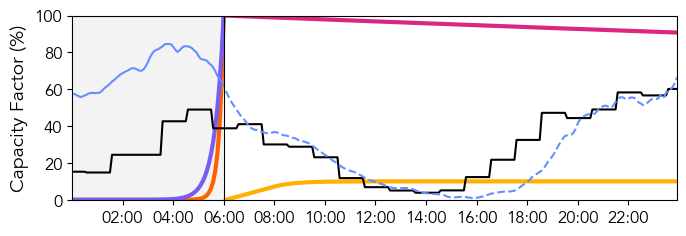

In [6]:
def _plot_forecast_parameters(_ax, f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t,
                              labels_1 = False,
                              labels_2 = False):

    tau_ = dt_[:t]
    s_   = dt_[t:]
    dt   = dt_[1] - dt_[0]

    _ax.plot(tau_ + dt, 100.0 * f_, 
             c=palette_.loc[0, "ibm"], 
             label="CF (actual)" if labels_1 else None, 
             lw=1.5, 
             zorder=5)

    _ax.plot(s_ + dt, 100.0 * f_hat_, 
             c=palette_.loc[0, "ibm"], 
             lw=1.5, 
             ls="--", 
             zorder=5)

    _ax.plot(dt_ + dt, 100.0 * e_, 
             lw=1.5, 
             label="CF (forecast)" if labels_1 else None, 
             c="k", 
             zorder=4)

    _ax.axvline(dt_[t - 1] + dt, 
                color="k", 
                lw=0.75, 
                label="Event (update)" if labels_1 else None, 
                zorder=6)
    
    _ax.fill_between(tau_ + dt, 100.0 * np.ones(tau_.shape), 100.0 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.25,
                     zorder=1)

    _ax.plot(tau_ + dt, 100.0 * phi_,
             c=palette_.loc[3, "ibm"],
             lw=3,
             label=r"$\phi_{\varepsilon_f} (\tau)$" if labels_2 else None,
             zorder=2)
    
    _ax.plot(tau_ + dt, 100.0 * psi_[:t],
             c=palette_.loc[1, "ibm"],
             lw=3,
             label=r"$\phi_{\varepsilon_e} (\tau)$" if labels_2 else None,
             zorder=2)

    _ax.plot(s_ + dt, 100.0 * psi_[t:],
             c=palette_.loc[2, "ibm"],
             lw=3,
             label=r"$\psi_{\eta} (s)$" if labels_2 else None,
             zorder=2)

    _ax.plot(s_ + dt, 100.0 * eta_,
             c=palette_.loc[4, "ibm"],
             lw=3,
             label=r"$\sigma_{\alpha} (s)$" if labels_2 else None,
             zorder=2)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    _ax.tick_params(axis="both", labelsize=12)
    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])

    if labels_1 | labels_2:
        _ax.legend(frameon=False, 
                   ncol=1, 
                   #loc="upper left", 
                   fontsize=12)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(6.75, 2.25), 
                        layout="constrained")

_plot_forecast_parameters(_ax, f_, e_, f_hat_, 
                          _meta['phi'], _meta['psi'], _meta['eta'], 
                          dx_, dt_, t,
                          labels_1 = False,
                          labels_2 = False)

plt.savefig(path_to_images + f"/parameters_{file_name}.png", 
            bbox_inches = "tight", 
            dpi = 600)

plt.show()

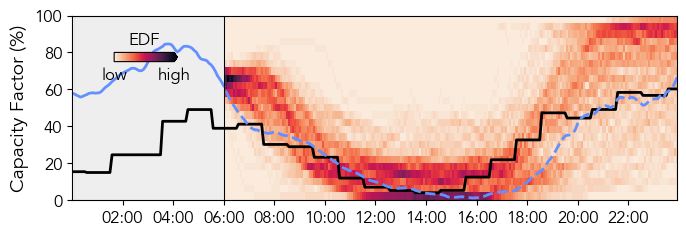

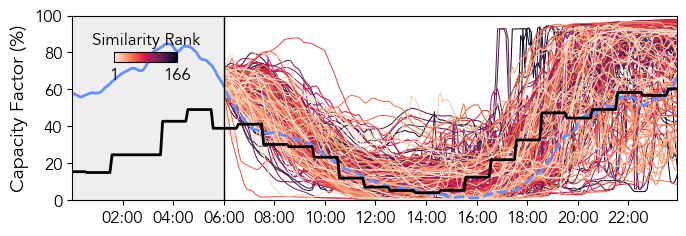

NameError: name '_downsample' is not defined

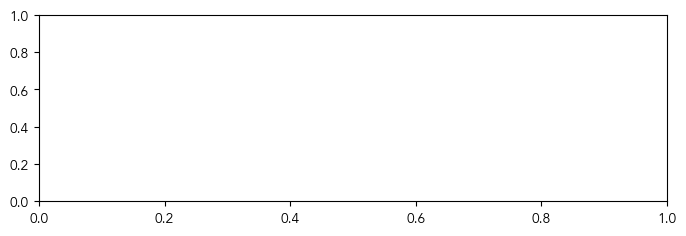

In [7]:
def _plot_updates(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, idx_, dx_, dt_, t, 
                  colorbar = True, 
                  legend = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]
    dt   = dt_[1] - dt_[0]

    #z_   = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_  = idx_[np.argsort(w_[idx_])]
    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1)

    _ax.plot([], [], 
             label = r"$\hat{\mu}_i(s)$", 
             c     = "orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_[t:] + dt, 100 * M_[j, :],
                 c  = _cmap(_norm(j/idx_.shape[0])), 
                 lw = 0.75)

    _ax.fill_between(tau_ + dt, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color  = "lightgray",
                     alpha  = 0.375)

    _ax.plot(tau_ + dt, 100.0 * f_,
             c     = palette_.loc[0, "ibm"],
             label = "CF (actual)",
             lw    = 2)

    _ax.plot(s_ + dt, 100.0 * f_hat_,
             c  = palette_.loc[0, "ibm"],
             lw = 2,
             ls = "--")

    _ax.plot(dt_ + dt, 100.0 * e_, 
             lw    = 2, 
             label = "CF (forecast)", 
             c     = "k")
    
    _ax.axvline(dt_[t - 1] + dt, 
                color  = "k", 
                lw     = 1, 
                label  = "Event (update)", 
                zorder = 10)
    
    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation = 0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size = 14)
    
    _ax.tick_params(axis      = "both", 
                    labelsize = 12)

    if legend:
        _ax.legend(frameon  = False, 
                   loc      = "upper right",
                   fontsize = 12, 
                   ncol     = 1)
    
    if colorbar:
        cbar = _fig.colorbar(cm.ScalarMappable(_norm, sns.color_palette("rocket_r", as_cmap=True)),
                             cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                             orientation="horizontal")
    
        cbar.set_ticks([0, 1], 
                       labels = [1, M_.shape[0]], 
                       size   = 12)
        
        cbar.ax.tick_params(length=0)
        
        cbar.ax.set_title("Similarity Rank", 
                          rotation = 0, 
                          size     = 12)
    
def _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, legend = True, colorbar = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]
    dt   = dt_[1] - dt_[0]

    Z_ = []
    for i in range(M_.shape[1]):
        a_, b_ = np.histogram(100 * M_[:, i], 
                              bins    = 25, 
                              range   = (0, 100), 
                              density = True)
        Z_.append(a_)

    Z_     = np.stack(Z_).T
    X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1]) / 2.0)

    _cmap = sns.color_palette("rocket_r", as_cmap = True)
    _ax.pcolormesh(X_ + dt, Y_, Z_, cmap = _cmap)

    _ax.plot(dt_ + dt, 100 * e_, 
             c     = "k", 
             lw    = 2, 
             label = "CF (forecast)")

    _ax.plot(tau_ + dt, 100 * f_,
             c     = palette_.loc[0, "ibm"],
             lw    = 2,
             label = "CF (actual)")

    _ax.plot(s_ + dt, 100 * f_hat_, 
             c  = palette_.loc[0, "ibm"], 
             lw = 2, 
             ls = "--")

    _ax.fill_between(tau_ + dt, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color = "lightgray",
                     alpha = 0.375)

    _ax.axvline(dt_[t - 1] + dt, 
                color     = "k", 
                linewidth = 0.75, 
                label     = "Event (update)")

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation = 0)
    _ax.set_ylabel("Capacity Factor (%)", size = 14)

    _ax.tick_params(axis = "both", labelsize = 12)

    _ax.set_ylim(0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])

    if legend:
        _ax.legend(frameon  = False, 
                   loc      = "upper right",
                   fontsize = 12, 
                   ncol     = 1)
    if colorbar:
        cbar = fig.colorbar(cm.ScalarMappable(cmap=_cmap),
                            cax         = _ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                            orientation = "horizontal",
                            extend      = "max")
    
        cbar.set_ticks([0, 1], 
                       labels   = ["low", "high"], 
                       fontsize = 12)
        
        cbar.ax.tick_params(length=0)
    
        cbar.ax.set_title("EDF", rotation=0)


# Derive central bands from a functional depth metric
def _central_bands_from_fDepth(M_, D_, alpha_):

    I_ = np.argsort(D_)[::-1]

    _y_pred_upper = {}
    _y_pred_lower = {}
    for i in range(len(alpha_)):
        scen_                         = M_[I_[:-int(M_.shape[0] * alpha_[i])],]
        _y_pred_upper[f'{alpha_[i]}'] = np.max(scen_, axis = 0)
        _y_pred_lower[f'{alpha_[i]}'] = np.min(scen_, axis = 0)

    m_ = M_[I_[0],]

    return m_, _y_pred_upper, _y_pred_lower
    
fig, _ax = plt.subplots(1, 1, 
                        figsize = (6.75, 2.25), 
                        layout  = "constrained")

_plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, 
                      legend   = False, 
                      colorbar = True)

plt.savefig(path_to_images + f"/EDF_heatmap_{file_name}.png", 
            bbox_inches = "tight", 
            dpi         = 600)

plt.show()

_fig, _ax = plt.subplots(1, 1, 
                        figsize = (6.75, 2.25), 
                        layout  = "constrained")


_plot_updates(_fig, _ax, palette_, M_, f_, e_, f_hat_, _meta['w'], _meta['idx_4'], dx_, dt_, t, 
              legend   = False, 
              colorbar = True)

plt.savefig(path_to_images + f"/dynamic_update_neighbors_{file_name}.png", 
            bbox_inches = "tight", 
            dpi         = 600)

plt.show()

fig, _ax = plt.subplots(1, 1, 
                        figsize = (6.75, 2.25), 
                        layout  = "constrained")

depth = 'DQ'
M_downsampled_, dt_p_ = _downsample(M_, dt_, _meta['m_0'], subsample = 6)
depth_rank_           = _fDepth(M_downsampled_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, depth_rank_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.png", 
            bbox_inches = "tight", 
            dpi         = 600)

plt.show()


(166, 216) (166, 217)


NameError: name '_fig' is not defined

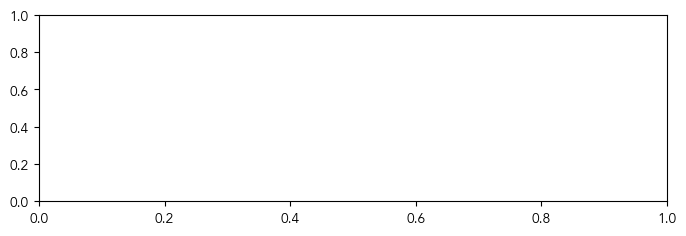

In [6]:
# Downsample collection of curvers
def _functional_downsampling(X_, x_, dt_, subsample, n_basis = 20):

    n_samples, n_points = X_.shape

    X_ = np.concatenate([x_, X_], axis = 1)
    # Ensure the length is divisible by subsample
    dt    = dt_[1] - dt_[0]
    t_    = dt_[-n_points-1:]
    t_ds_ = np.linspace(t_[1], t_[-1], int(n_points/subsample))

    # Create an FDataGrid object
    data_ = [X_[i, :] for i in range(n_samples)]
    _fd   = FDataGrid(data_matrix = data_, grid_points = t_)

    # Interpolate first (useful if data are unevenly spaced or need smoothing)
    _fd_interp = _fd.to_basis(BSpline(n_basis = n_basis))
    M_interp_  = _fd_interp.to_grid(t_)
    M_interp_  = np.stack([M_interp_.data_matrix[i] 
                           for i in range(n_samples)])[..., 0]
    
    # Re-evaluate existing data
    M_interp_ds_ = _fd_interp.to_grid(t_ds_)
    M_interp_ds_ = np.stack([M_interp_ds_.data_matrix[i] 
                             for i in range(n_samples)])[..., 0]

    return M_interp_, M_interp_ds_, t_ds_

def _plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, dx_, dt_, 
                legend = True,
                colorbar = True):

    t    = dt_.shape[0] - M_.shape[1]
    tau_ = dt_[:t]
    s_   = dt_[t:]
    dt   = dt_[1] - dt_[0]

    idx_  = np.argsort(w_)
    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1)

    _ax.plot([], [], 
             label = r"$\hat{\mu}_i(s)$", 
             c     = "orange")

    for i in range(idx_.shape[0]):
        _ax.plot(s_ + dt, 100 * M_[idx_[i], :],
                 c      = _cmap(_norm(i/idx_.shape[0])), 
                 lw     = 0.75, 
                 zorder = 8)
        
    _ax.fill_between(tau_ + dt, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color  = "lightgray",
                     alpha  = 0.375,
                     zorder = 1)

    _ax.plot(dt_[:f_.shape[0]] + dt, 100.0 * f_,
             c      = palette_.loc[0, "ibm"],
             label  = "CF (ac)",
             lw     = 2)

    _ax.plot(dt_[-f_hat_.shape[0]:] + dt, 100.0 * f_hat_,
             c      = palette_.loc[0, "ibm"],
             lw     = 2,
             ls     = "--")

    _ax.plot(dt_ + dt, 100.0 * e_, 
             lw     = 2, 
             label  = "CF (fc)", 
             c      = "k")

    _ax.axvline(dt_[f_.shape[0] - 1] + dt, 
                color  = "k", 
                lw     = 1, 
                label  = "Event (update)", 
                zorder = 10)
    
    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0., 100.)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    
    _ax.tick_params(axis      = "both", 
                    labelsize = 12)
    
    if legend:
        _ax.legend(frameon  = False, 
                   fontsize = 12, 
                   ncol     = 1)

    if colorbar:
        cbar = _fig.colorbar(cm.ScalarMappable(_norm, sns.color_palette("rocket_r", as_cmap = True)),
                             cax         = _ax.inset_axes([100, 75, 150, 5], transform = _ax.transData),
                             orientation = "horizontal")
    
        cbar.set_ticks([0, 1], 
                       labels = [1, M_.shape[0]], 
                       size   = 12)
            
        cbar.ax.set_title("Depth Rank", 
                          rotation = 0, 
                          size     = 12)
    
m_0_ = np.ones(_meta['m_0'].shape)*f_[-1]
M_interp_, M_interp_ds_, dt_p_ = _functional_downsampling(M_, m_0_, dt_,
                                                          subsample = 3,
                                                          n_basis   = 20)                                                      

fig, _ax = plt.subplots(1, 1, 
                        figsize = (6.75, 2.25), 
                        layout  = "constrained")

depth = 'DQ'
depth_rank_ = _fDepth(M_interp_ds_, depth, path_to_fDepth).to_numpy()[:, 0]
print(M_.shape, M_interp_.shape)
_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, depth_rank_, dx_, dt_, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.png", 
            bbox_inches = "tight", 
            dpi         = 600)

plt.show()

(72,)


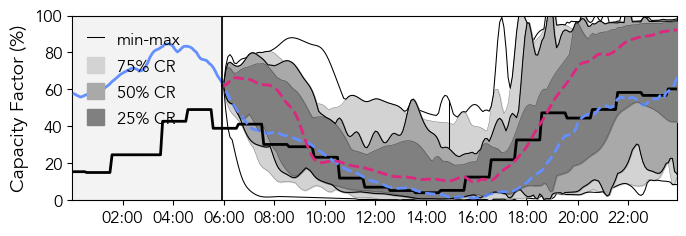

In [7]:
def _plot_enhanced_functional_boxplot(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_,
                                      legend_1 = True, 
                                      legend_2 = True):

    t    = dt_.shape[0] - m_.shape[0]
    tau_ = dt_[:t]
    s_   = dt_[t:]
    dt   = dt_[1] - dt_[0]

    _ax.plot(dt_ + dt, 100*e_, 
             c      = "k", 
             lw     = 2, 
             zorder = 4,
             label  = "CF (forecast)" if legend_1 else None)

    _ax.plot(dt_[:f_.shape[0]] + dt, 100*f_, 
             c      = palette_.loc[0, "ibm"], 
             label  = "CF (actual)" if legend_1 else None, 
             zorder = 4,
             lw     = 2)

    _ax.plot(dt_[-f_hat_.shape[0]:] + dt, 100*f_hat_, 
             c      = palette_.loc[0, "ibm"], 
             zorder = 4,
             ls     = "--", 
             lw     = 2)
    
    m_p_ = np.concatenate([f_[-1] * np.ones((1,)), m_], axis=0)
    _ax.plot(dt_[-m_p_.shape[0]:] + dt, 100*m_p_, 
             c      = palette_.loc[2, "ibm"], 
             ls     = '--',
             zorder = 4,
             label  = r"$\bar{\mu} (s)$" if legend_1 else None,
             lw     = 2)

    upper_p_ = np.concatenate([f_[-1] * np.ones((1,)), _upper['max']], axis=0)
    _upper.pop('max')

    _ax.plot(dt_[-upper_p_.shape[0]:] + dt, 100 * upper_p_, 
             c  = 'k', 
             lw = .75)
    
    lower_p_ = np.concatenate([f_[-1] * np.ones((1,)), _lower['min']], axis=0)
    _lower.pop('min')
    
    _ax.plot(dt_[-lower_p_.shape[0]:] + dt, 100*lower_p_, 
             c     = 'k', 
             lw    = .75, 
             label = "min-max" if legend_2 else None)

    t_mdl_ = lower_p_.shape[0] // 2
    _ax.vlines(x      = dt_[-t_mdl_], 
               ymin   = 100*lower_p_[-t_mdl_ - 1], 
               ymax   = 100*upper_p_[-t_mdl_ - 1], 
               color  = 'k', 
               lw     = .75, 
               zorder = 2)

    colors_ = ["lightgray", "darkgray", "gray"]
    
    for color, key, i in zip(colors_, _upper.keys(), range(len(_upper.keys()))):
        u_ = np.concatenate([f_[-1] * np.ones((1,)), _upper[key]], axis=0)
        l_ = np.concatenate([f_[-1] * np.ones((1,)), _lower[key]], axis=0)
    
        _ax.plot(dt_[-upper_p_.shape[0]:] + dt, 100*u_, 
                 lw     = 0.125, 
                 zorder = i + 2,
                 c      = "k")
        
        _ax.plot(dt_[-lower_p_.shape[0]:] + dt, 100*l_, 
                 lw     = 0.125, 
                 zorder = i + 2,
                 c      = "k")

        cr = int((1. - float(key))*100)
        
        _ax.fill_between(dt_[-upper_p_.shape[0]:] + dt, 100*u_, 100*l_,
                        color  = color,
                        label  = f"{cr}% CR" if legend_2 else None,
                        zorder = i + 1)

    upper_p_ = np.concatenate([f_[-1] * np.ones((1,)), _upper['0.5']], axis=0)
    lower_p_ = np.concatenate([f_[-1] * np.ones((1,)), _lower['0.5']], axis=0)

    _ax.plot(dt_[-lower_p_.shape[0]:] + dt, 100 * lower_p_, 
             c      = 'k', 
             zorder = 3,
             lw     = .75)

    _ax.plot(dt_[-upper_p_.shape[0]:] + dt, 100 * upper_p_, 
             zorder = 3,
             c      = 'k', 
             lw     = .75)
        
    _ax.axvline(dt_[t - 1] + dt, 
                color     = "k", 
                ls        = '-',
                linewidth = 1.25, 
                label     = "Event (update)" if legend_1 else None, 
                zorder    = 10)
    
    _ax.fill_between(tau_ + dt, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color = "lightgray",
                     alpha = 0.25)
    
    if legend_1 | legend_2: 
        _ax.legend(frameon  = False, 
                   loc      = "upper left",
                   fontsize = 12,
                   ncol     = 1)
        
    _ax.tick_params(axis      = "both", 
                    labelsize = 12)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0., 100.)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    

# Derive confidence intervals from a smooth functional depth metric
def _functional_boxplot(M_downsampled_, 
                        M_upsampled_,
                        alpha_, 
                        depth, 
                        path):

    # Calculate functional depth ranking
    D_ = _fDepth(M_downsampled_, depth, path).to_numpy()[:, 0]

    I_ = np.argsort(D_)[::-1]

    _y_pred_upper = {}
    _y_pred_lower = {}
    for i in range(len(alpha_)):
        scen_ = M_upsampled_[I_[:-int(M_upsampled_.shape[0] * alpha_[i])],]
        
        _y_pred_upper[f'{alpha_[i]}'] = np.max(scen_, axis = 0)
        _y_pred_lower[f'{alpha_[i]}'] = np.min(scen_, axis = 0)

    m_ = M_upsampled_[I_[0],]

    _y_pred_upper['max'] = np.max(M_upsampled_, axis = 0)
    _y_pred_lower['min'] = np.min(M_upsampled_, axis = 0)

    return m_, _y_pred_upper, _y_pred_lower
    
m_0_ = np.ones(_meta['m_0'].shape)*f_[-1]
M_interp_, M_interp_ds_, dt_p_ = _functional_downsampling(M_, m_0_, dt_,
                                                          subsample = 12,
                                                          n_basis   = int(M_.shape[1]/4)) 

# Calculate confidence intervals from Directional Quantiles
alpha_ = [0.25, 0.5, 0.75]
depth  = 'MBD'

m_, _upper, _lower = _functional_boxplot(M_interp_ds_, 
                                         M_interp_,
                                         alpha_, 
                                         depth, 
                                         path_to_fDepth)

print(f_.shape)
_fig, _ax = plt.subplots(1, 1, 
                        figsize = (6.75, 2.25), 
                        layout  = "constrained")

_plot_enhanced_functional_boxplot(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_,
                                  legend_1 = False, 
                                  legend_2 = True)

plt.savefig(path_to_images + f"/fboxplot_{file_name}.png", 
            bbox_inches = "tight", 
            dpi         = 600)

plt.show()


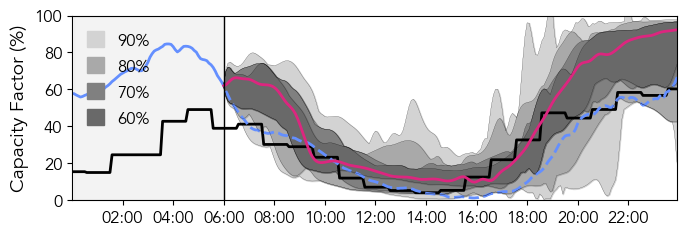

In [8]:
def _focal_curve_envelope(_depth, Y_, dt_, dist_, max_iter = 100):
    """
    Envelope algorithm to obtain functional neighbourhoods.

    Parameters
    ----------
    data : dict
        Dictionary with keys:
            - "x": np.ndarray of grid points (n_points,)
            - "y": np.ndarray of function values (n_points, n_curves)
    focal : int or str
        Index (or column name) of the focal curve to envelope.
    plot : bool, optional
        Whether to plot the selected curves in each iteration.
    max_iter : int, optional
        Maximum number of iterations before stopping.

    Returns
    -------
    dict
        Dictionary with key 'Jordered' containing the ordered list
        of selected curve indices.
    """
    
    # Compute depth to find the focal-curve
    _fd_filtered = FDataGrid(data_matrix = Y_.T,
                             grid_points = dt_)
    
    filtered_depth_ = _depth(_fd_filtered)
    idx_focal       = np.argsort(-filtered_depth_)[0]
    f_              = Y_[:, idx_focal]

    # Distances from curves to the focal-curve
    if dist_ == 'sup':
        dist_ = np.max(np.abs(Y_.T - f_), axis = 1)
    elif dist_ == 'l2':
        dist_ = np.sum((Y_.T - f_)**2, axis = 1)
            
    # Initialize
    idx_subsample = []
    idx_          = [i for i in range(Y_.shape[1]) if i != idx_focal]
    iter_depth    = [0]
    iteration     = 0

    while len(idx_) > 1:
        
        # New interation
        iteration += 1
        
        # Sort curves by distance
        idx_sorted_dist_   = [idx_[i] for i in np.argsort(dist_[idx_])]
        idx_iter_subsample = [idx_sorted_dist_[0]]
        idx_candidates     = idx_sorted_dist_[1:]

        # Iterative envelope selection
        remaining_points = set(dt_)
        while remaining_points and idx_candidates:
            idx_next = idx_candidates[0]
            combined = idx_iter_subsample + [idx_next]
            
            # Check if envelops
            sign_ = np.sign(Y_[:, combined].T - f_)
            Ji_   = np.where(np.abs(np.sum(sign_, axis = 0)) < len(combined))[0]
            
            if len(remaining_points - set(dt_[Ji_]) ) == len(remaining_points):
                # Does not envelope
                idx_candidates.pop(0)
            else:
                remaining_points -= set(dt_[Ji_])
                
                idx_iter_subsample.append(idx_next)
                
                idx_candidates = [c for c in idx_candidates if c not in idx_iter_subsample]
                idx_           = [c for c in idx_ if c not in idx_iter_subsample]

        # Compute functional depth 
        _fd_subset = FDataGrid(data_matrix = (Y_[:, [idx_focal] 
                                                + idx_subsample 
                                                + idx_iter_subsample]).T,
                               grid_points = dt_)
        
        depth_             = _depth(_fd_subset)
        idx_depth_         = np.argsort(-depth_)
        idx_ordered_depth_ = np.array([idx_focal] + idx_subsample + idx_iter_subsample)[idx_depth_]

        # How deep the new set of curves is?
        depth_percentile = 1 - np.where(idx_ordered_depth_ == idx_focal)[0][0]/(len(idx_ordered_depth_) - 1)
        
        iter_depth.append(depth_percentile)

        # Accept subsample if depth improves
        if max(iter_depth[:-1]) <= iter_depth[-1]:
            idx_subsample.extend(idx_iter_subsample)
            
        # Stop if there is not more candidate curves
        if not idx_candidates:
            break
            
        # Stop if max_iter is reached
        if iteration >= max_iter:
            break

    # Selected curves
    idx_sel_ = [idx_focal] + idx_subsample
    
    # Final selected curves ordered by depth
    _fd_filtered = FDataGrid(data_matrix = Y_[:, idx_sel_].T,
                             grid_points = dt_)
        
    filtered_depth_             = _depth(_fd_filtered)
    idx_filtered_depth_         = np.argsort(-filtered_depth_)
    idx_ordered_filtered_depth_ = np.array(idx_sel_)[idx_filtered_depth_]

    return Y_[:, idx_ordered_filtered_depth_]

def _plot_envelop(_ax, J_, k_, alpha_, f_, e_, f_hat_, dt_, dx_, t, 
                  legend_1 = True, 
                  legend_2 = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]
    s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)
    dt   = dt_[1] - dt_[0]

    m_ = J_[:, 0]
    J_ = J_[:, 1:]

    _ax.plot(dt_ + dt, 100 * e_, 
             c      = "k", 
             lw     = 2, 
             label  = "CF (forecast)" if legend_1 else None)

    _ax.plot(tau_ + dt, 100 * f_, 
             c      = palette_.loc[0, "ibm"], 
             label  = "CF (actual)" if legend_1 else None, 
             lw     = 2)
    
    _ax.plot(s_ + dt, 100 * f_hat_, 
             c      = palette_.loc[0, "ibm"], 
             ls     = "--", 
             lw     = 2)

    _ax.plot(s_p_ + dt, 100 * m_, 
            c      = palette_.loc[2, "ibm"], 
            label  = r"$\bar{\mu} (s)$" if legend_1 else None,
            lw     = 2)
    
    _ax.axvline(dt_[t - 1] + dt, 
                color     = "k", 
                linewidth = 1.0, 
                label     = "Event (update)" if legend_1 else None, 
                zorder    = 10)

    colors_ = ["lightgray", "darkgray", "gray", "dimgray"]
    for k, alpha, color in zip(k_, alpha_, colors_):
        
        ci = int((1. - alpha)*100)
        u_ = np.max(J_[:, :k], axis = 1)
        l_ = np.min(J_[:, :k], axis = 1)

        _ax.plot(s_p_ + dt, 100 * u_, 
                 lw = 0.125, 
                 c  = "k")
        
        _ax.plot(s_p_ + dt, 100 * l_, 
                 lw = 0.125, 
                 c  = "k")

        _ax.fill_between(s_p_ + dt, 100 * u_, 100 * l_,
                         color  = color,
                         alpha  = 1,
                         label  = f"{ci}%" if legend_2 else None,
                         zorder = 1)
            
    _ax.fill_between(tau_ + dt, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color = "lightgray",
                     alpha = 0.25)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    
    if legend_1 | legend_2: 
        _ax.legend(frameon  = False, 
                   loc      = "upper left",
                   fontsize = 12,
                   ncol     = 1)
        
    _ax.tick_params(axis      = "both", 
                    labelsize = 12)
    
    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size = 14)

    
m_0_ = np.ones(_meta['m_0'].shape)*f_[-1]
M_interp_, M_interp_ds_, dt_p_ = _functional_downsampling(M_, m_0_, dt_,
                                                          subsample = 12,
                                                          n_basis   = int(M_.shape[1]/4)) 
_ID  = IntegratedDepth()
_MBD = ModifiedBandDepth()

J_ = _focal_curve_envelope(_MBD, 
                           Y_    = M_interp_.T, 
                           dt_   = dt_[-M_interp_.shape[1]:], 
                           #dist_ = _meta['w'][_meta['idx_4']])
                           dist_ = 'sup')
                           #dist_ = 'l2')

_fig, _ax = plt.subplots(1, 1, 
                        figsize = (6.75, 2.25), 
                        layout  = "constrained")

# Samples in each confidence band
alpha_ = [0.1, 0.2, 0.3, 0.4]
k_     = [80, 40, 20, 10]

_plot_envelop(_ax, J_, k_, alpha_, f_, e_, f_hat_, dt_, dx_, t, 
              legend_1 = False, 
              legend_2 = True)

plt.savefig(path_to_images + f"/fenvelop_{file_name}.pdf", 
            bbox_inches = "tight", 
            dpi         = 600)

plt.show()

(217, 150)


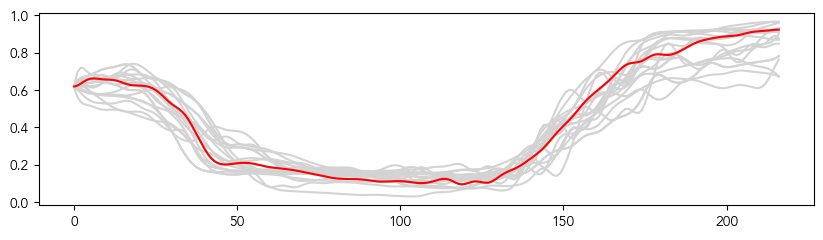

(217, 145)


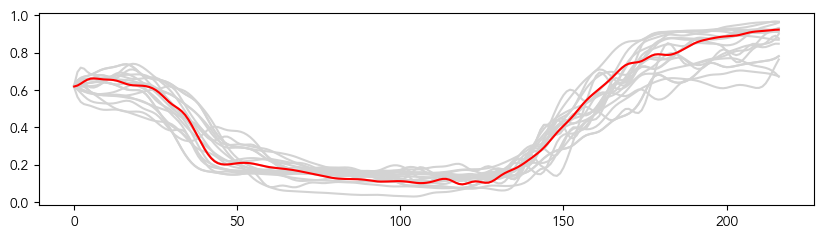

(217, 164)


 /var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_13306/3627534033.py:34: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 /var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_13306/3627534033.py:36: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


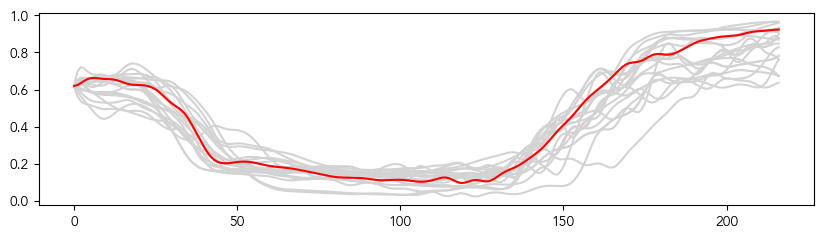

In [9]:
m_0_ = np.ones(_meta['m_0'].shape)*f_[-1]
M_interp_, M_interp_ds_, dt_p_ = _functional_downsampling(M_, m_0_, dt_,
                                                          subsample = 12,
                                                          n_basis   = int(M_.shape[1]/4)) 
_ID  = IntegratedDepth()
_MBD = ModifiedBandDepth()

J_ = _focal_curve_envelope(_MBD, 
                           Y_    = M_interp_.T, 
                           dt_   = dt_[-M_interp_.shape[1]:], 
                           dist_ = 'sup')
print(J_.shape)

plt.figure(figsize = (10, 2.5))
for i in range(20):
    plt.plot(J_[:, i], c = 'lightgray')
plt.plot(J_[:, 0], c = 'r')
plt.show()

J_ = _focal_curve_envelope(_MBD, 
                           Y_    = M_interp_.T, 
                           dt_   = dt_[-M_interp_.shape[1]:], 
                           dist_ = 'l2')
print(J_.shape)

plt.figure(figsize = (10, 2.5))
for i in range(20):
    plt.plot(J_[:, i], c = 'lightgray')
plt.plot(J_[:, 0], c = 'r')
plt.show()

J_ = _focal_curve_envelope(_MBD, 
                           Y_    = M_interp_.T, 
                           dt_   = dt_[-M_interp_.shape[1]:], 
                           dist_ = _meta['w'][_meta['idx_4']])
print(J_.shape)

plt.figure(figsize = (10, 2.5))
for i in range(20):
    plt.plot(J_[:, i], c = 'lightgray')
plt.plot(J_[:, 0], c = 'r')
plt.show()

In [18]:
# Boostrapped confidence intervals derived from a functional depth metric
def _bootrapped_confidence_intervals_from_fDepth(M_, alpha_, depth, path):

    # Calculate functional depth ranking
    m_, inf_, sup_ = _bootstrap_fDepth(M_, alpha_, depth, path)

    _y_pred_upper = {}
    _y_pred_lower = {}
    for i in range(len(alpha_)):
        _y_pred_upper[f'{alpha_[i]}'] = inf_.loc[i].to_numpy()
        _y_pred_lower[f'{alpha_[i]}'] = sup_.loc[i].to_numpy()

    return m_, _y_pred_upper, _y_pred_lower

m_, _upper, _lower = _bootrapped_confidence_intervals_from_fDepth(M_, alpha_, depth, path_to_fDepth)

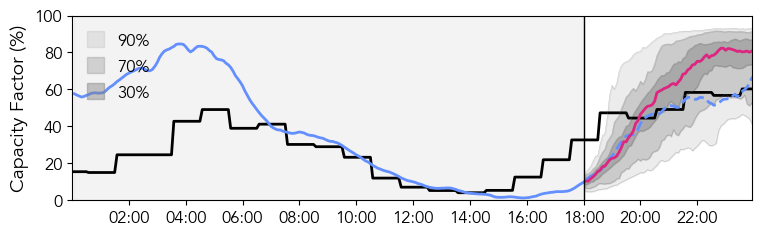

In [19]:
# Calculate confidence intervals from Directional Quantiles
alpha_ = [0.1, 0.3, 0.7]
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)

_fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, t, 
              legend_1 = False, 
              legend_2 = True)

plt.savefig(path_to_images + f"/EDF_envelop_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

10 (100, 72)
30 (100, 72)
70 (100, 72)


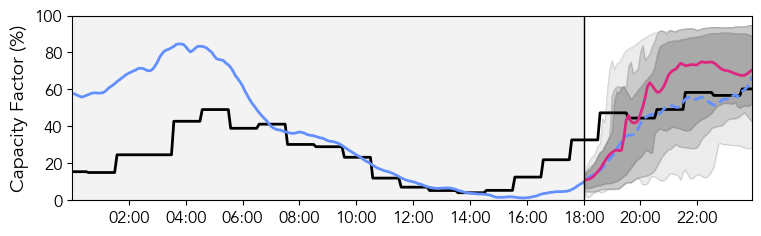

In [20]:
# Calculate confidence intervals from Directional Quantiles
alpha_ = [0.1, 0.3, 0.7]
depth  = 'DQ'

m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, depth, path_to_fDepth)

_fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")


_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, t, 
              legend_1 = False, 
              legend_2 = False)

plt.savefig(path_to_images + f"/{depth}_envelop_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

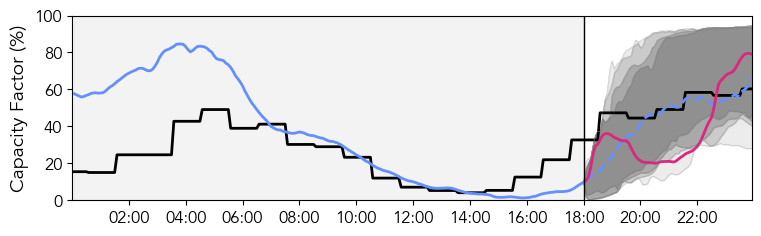

In [21]:
# Calculate confidence intervals from Directional Quantiles
alpha_ = [0.1, 0.2, 0.3, 0.4]
depth  = 'LD'
m_, _upper, _lower = _bootrapped_confidence_intervals_from_fDepth(M_, alpha_, depth, path_to_fDepth)

_fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, t, 
              legend_1 = False, 
              legend_2 = False)

plt.savefig(path_to_images + f"/{depth}_bootstrap_envelop_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

wind-30-90-72
Bull Creek Wind Farm 2018-04-01 06:00:00


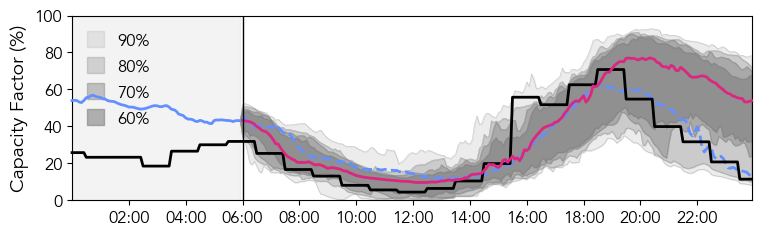

In [138]:
for i in [6]:

    a = 30
    d = 90
    t = i * 12
    file_name = f"{resource}-{a}-{d}-{t}"
    print(file_name)
    
    f_     = F_ts_[d, :t, a]
    e_     = E_ts_[d, :, a]
    x_     = x_ts_[a, :]
    time   = t_ts_[d]
    f_hat_ = F_ts_[d, t:, a]
    
    _meta, M_ = _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, t_tr_, dt_, f_, e_, x_, time,
                                              forget_rate_f  = params_['forget_rate_f'][t],
                                              forget_rate_e  = params_['forget_rate_e'][t],
                                              length_scale_f = params_['length_scale_f'][t],
                                              length_scale_e = params_['length_scale_e'][t],
                                              lookup_rate    = params_['lookup_rate'][t],
                                              trust_rate     = params_['trust_rate'][t],
                                              nu             = params_['nu'][t],
                                              gamma          = params_['xi'][t],
                                              xi             = params_['gamma'][t],
                                              kappa_min      = params_['kappa_min'][t],
                                              kappa_max      = params_['kappa_max'][t], 
                                              idx_hours_     = idx_hours_)
    
    print(assets_ts_[a], T_ts_[d, t])

    # fig, _ax = plt.subplots(1, 1, 
    #                         figsize=(7.5, 2.25), 
    #                         layout="constrained")
    
    # _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, 
    #                       legend = False, 
    #                       colorbar = True)
    
    # plt.savefig(path_to_images + f"/EDF_heatmap_{file_name}.pdf", 
    #             bbox_inches="tight", 
    #             dpi=600)
    
    # plt.show()

    # _fig, _ax = plt.subplots(1, 1, 
    #                         figsize=(7.5, 2.25), 
    #                         layout="constrained")
    
    # depth = 'MBD'
    # d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]
    
    # _plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
    #             legend = False)
    
    # plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
    #             bbox_inches="tight", 
    #             dpi=600)
    
    # plt.show()

    _fig, _ax = plt.subplots(1, 1, 
                            figsize=(7.5, 2.25), 
                            layout="constrained")
    
    # Calculate confidence intervals from Directional Quantiles
    alpha_ = [0.1, 0.2, 0.3, 0.4]
    #m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, 'LD', path_to_fDepth)
    m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)
    
    _plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, t, 
                  legend_1 = False, 
                  legend_2 = True)
    
    plt.savefig(path_to_images + f"/BD_envelop_{file_name}.pdf", 
                bbox_inches="tight", 
                dpi=600)

0.32115088058343727
[-101.584    32.9331]


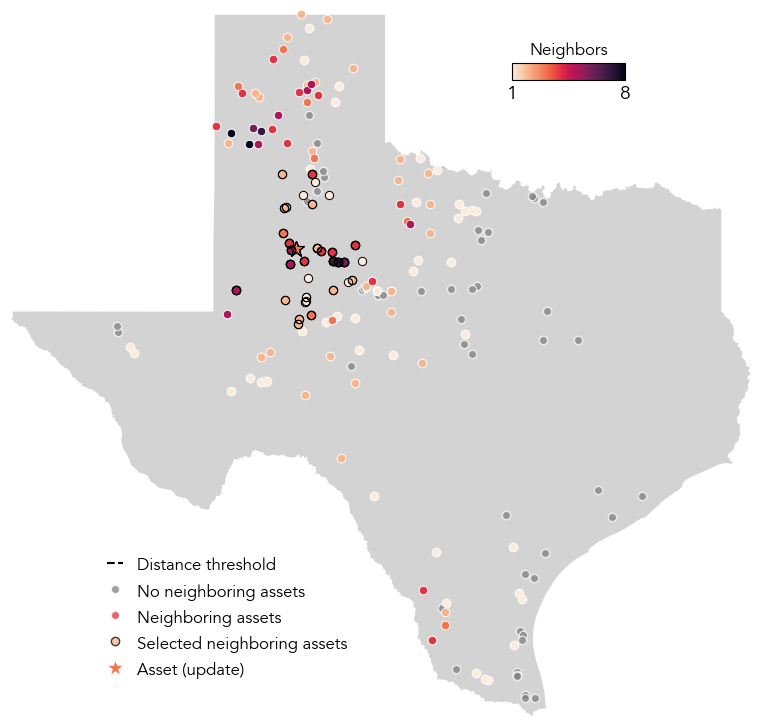

In [22]:
def _plot_frequency_map(_fig, _ax, TX_, x_tr_, x_ts_, x_, idx_1_, idx_2_, sigma):

    print(sigma)
    x_tr_p_, z_tr_p_ = np.unique(x_tr_[idx_1_, :], 
                                 return_counts = True, 
                                 axis = 0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _norm = plt.Normalize(1, z_tr_p_.max())

    TX_.plot(ax=_ax, 
             facecolor="lightgray", 
             edgecolor="white", 
             zorder=0)

    # _ax.scatter(x_[0], x_[1],
    #             c="lime",
    #             lw=1,
    #             ec="k",
    #             s=110,
    #             zorder=1,
    #             marker="o",
    #             clip_on=False,
    #             label="Asset (update)")
    
    _ax.plot(x_[0], x_[1],
             c="k",
             marker="None",
             ls="--",
             clip_on=False,
             label="Distance threshold")

    _ax.plot(x_ts_[:, 0], x_ts_[:, 1],
             c="gray",
             alpha=0.75,
             ms=6,
             marker="o",
             mec="w",
             ls="none",
             mew=1.0,
             zorder=2, clip_on=False,
             label="No neighboring assets")
    
    _ax.plot(x_[0], x_[1],
             c=_cmap(_norm(z_tr_p_.max() / 2.0)),
             alpha=0.75,
             ms=6,
             ls="none",
             marker="o",
             mec="w",
             mew=1.0,
             zorder=0, 
             clip_on=False,
             label="Neighboring assets")

    _ax.plot(x_[0], x_[1],
             c=_cmap(_norm(z_tr_p_.max() / 4.0)),
             alpha=0.75,
             ms=6,
             ls="none",
             marker="o",
             mec="k",
             mew=1.0,
             zorder=0, clip_on=False,
             label="Selected neighboring assets")
    print(x_)
    for i in np.arange(x_tr_p_.shape[0], dtype=int)[np.argsort(z_tr_p_)]:
        if (x_tr_p_[i, 0] != x_[0]) | (x_tr_p_[i, 1] != x_[1]):
            _ax.plot(x_tr_p_[i, 0], x_tr_p_[i, 1],
                     c=_cmap(_norm(z_tr_p_[i])),
                     ms=6,
                     ls="none",
                     marker="o",
                     mec="w",
                     mew=.5,
                     zorder=4, 
                     clip_on=False)
        else:
            _ax.plot(x_tr_p_[i, 0], x_tr_p_[i, 1],
                     c=_cmap(_norm(z_tr_p_[i])),
                     ms=12,
                     ls="none",
                     marker="*",
                     mec="w",
                     mew=.5,
                     zorder=4, 
                     clip_on=False, 
                     label = 'Asset (update)')

    
    for i in range(x_tr_[idx_2_, :].shape[0]):
        if (x_tr_[idx_2_[i], 0] != x_[0]) | (x_tr_[idx_2_[i], 1] != x_[1]):
            _ax.plot(x_tr_[idx_2_[i], 0], x_tr_[idx_2_[i], 1],
                     ms=6,
                     ls="none",
                     marker="o",
                     c = 'none', 
                     mec="k",
                     mew=.75,
                     zorder=5, 
                     clip_on=False)
        else:
            _ax.plot(x_tr_[idx_2_[i], 0], x_tr_[idx_2_[i], 1],
                     ms=12,
                     ls="none",
                     marker="*",
                     c = 'none', 
                     mec="k",
                     mew=.75,
                     zorder=5, 
                     clip_on=False)
    
    minx, miny, maxx, maxy = TX_.total_bounds
    X_, Y_ = np.meshgrid(np.linspace(minx, maxx, 1000), 
                         np.linspace(miny, maxy, 1000))
    
    Z_ = _haversine_dist(x_, np.concatenate([X_.flatten()[:, np.newaxis], 
                                             Y_.flatten()[:, np.newaxis]], axis = 1)).reshape(X_.shape)

    contours = _ax.contour(X_, Y_, Z_, 
                           levels = [sigma], 
                           colors = 'k', 
                           linewidths = 0.5, 
                           linestyles = 'dashed')

    cbar = _fig.colorbar(cm.ScalarMappable(cmap = _cmap),
                         cax=_ax.inset_axes([-97.75, 35.5, 2.0, 0.25], transform = _ax.transData),
                         orientation="horizontal")

    cbar.set_ticks([0, 1], 
                   labels=[1, int(z_tr_p_.max())], 
                   fontsize=14)
    
    cbar.ax.tick_params(length=0)
    
    cbar.ax.set_title("Neighbors", 
                      rotation = 0, 
                      fontsize = 12)

    _ax.legend(frameon=False,
               bbox_to_anchor=(0.475, 0.25),
               ncol=1,
               fontsize=12)
    
    _ax.set_axis_off()

_fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 7.5), 
                        layout="constrained")

        
_plot_frequency_map(_fig, _ax, TX_, x_tr_, x_ts_, x_ts_[a, :], _meta['idx_2'], _meta['idx_4'], _meta['Gamma'])

# # Add compass (North arrow)
# x, y, arrow_length = 0.1725, 0.95, 0.0625  # relative axes coords
# _ax.annotate("N",
#              xy=(x, y),
#              xytext=(x, y - arrow_length),
#              arrowprops=dict(facecolor="k", 
#                              arrowstyle="wedge,tail_width=1,shrink_factor=.5"),
#              ha="center",
#              va="center",
#              fontsize=14,
#              xycoords=_ax.transAxes)

# scalebar = ScaleBar(dx=100,  # scaling factor
#                     units="km",
#                     dimension="si-length",  # could also be 'imperial-length'
#                     location='upper left',
#                     length_fraction=0.09,  # fraction of the axis for bar length
#                     color="black",
#                     box_color="None",
#                     box_alpha=1.0,
#                     border_pad=9,
#                     font_properties={"size": 14})

# _ax.add_artist(scalebar)


plt.savefig(path_to_images + f"/spatial_neiboring_assets_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

 /var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_48789/2548354770.py:92: UserWarning:constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.


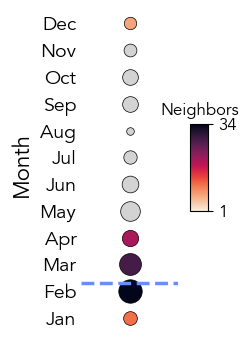

In [122]:
def _scenarios_frequency_dates(_ax, T_tr_, idx_1_, idx_2_, t_ts, 
                                xlabel = True,
                                colorbar = True):

    _date     = datetime.datetime.strptime(t_ts, "%Y-%m-%d %H:%M:%S")
    m_a       = _date.timetuple().tm_mon - 1
    day       = _date.timetuple().tm_mday - 1
    _, n_days = calendar.monthrange(_date.year, m_a + 1)

    m_tr_ = np.stack([datetime.datetime.strptime(T_tr_[i], "%Y-%m-%d %H:%M:%S").timetuple().tm_mon - 1
                      for i in range(T_tr_.shape[0])])

    month_name_ = ["Jan", "Feb", "Mar", "Apr",
                   "May", "Jun", "Jul", "Aug",
                   "Sep", "Oct", "Nov", "Dec"]
    
    months_, counts_ = np.unique(m_tr_[idx_1_], return_counts=True)

    counts_1_ = np.zeros(12)
    for month, count in zip(months_, counts_):
        counts_1_[month] = count

    months_, counts_ = np.unique(m_tr_[idx_2_], return_counts=True)

    counts_2_ = np.zeros(12)
    for month, count in zip(months_, counts_):
        counts_2_[month] = count

    months_ = np.arange(12, dtype = int)
    jitter_strength = 0.5
    x_ = 0. + np.random.normal(0, jitter_strength, size=months_.shape[0])*0.

    counts_2_p_ = counts_2_.copy()
    counts_2_p_[counts_2_ == 0] = np.nan

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _cmap.set_bad(color= 'lightgray')  # RGBA: transparent
    _norm = plt.Normalize(1, counts_2_.max())
    
    for i in range(x_.shape[0]):
        # Plot
        _ax.scatter(x_[i], months_[i], 
                    s=counts_1_[i]*2.5,
                    color=_cmap(_norm(counts_2_p_[i])),
                    edgecolor='k',
                    vmin = 1, vmax = 150,
                    linewidth=0.5, 
                    clip_on = False,
                    zorder = 6)

    _ax.set_xlim(-5, 5)

    _ax.set_xticks(x_, []*len(x_))
    
    _ax.set_ylabel("Month", size=16)
    
    _ax.set_yticks(np.arange(len(month_name_), dtype=int), month_name_,
                   size=14)
    
    _ax.tick_params(axis='y', length=0)
    _ax.tick_params(axis='x', length=0)

    _ax.axhline(m_a + day/n_days, 
                color=palette_.loc[0, "ibm"], 
                ls = '--',
                lw=2.5, 
                zorder=6)
    
    cbar = _fig.colorbar(cm.ScalarMappable(cmap = _cmap),
                         cax=_ax.inset_axes([5, 4, 1.5, 3.25], transform = _ax.transData))

    cbar.set_ticks([0, 1], 
                   labels=[1, int(counts_2_.max())], 
                   fontsize=12)
        
    cbar.ax.set_title("Neighbors", 
                      rotation = 0, 
                      fontsize = 12)
    _ax.set_xlim(-4, 4)

    sns.despine(left=True, bottom=True) 

fig, _ax = plt.subplots(1, 1, 
                        figsize=(1.25, 4), 
                        layout="constrained")


_scenarios_frequency_dates(_ax, T_tr_[:, t], _meta['idx_1'], _meta['idx_4'], T_ts_[d, t], 
                            xlabel = True,
                            colorbar = True)

plt.savefig(path_to_images + f"/temporal_neiboring_assets_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

plt.show()


1 9
662 Feb


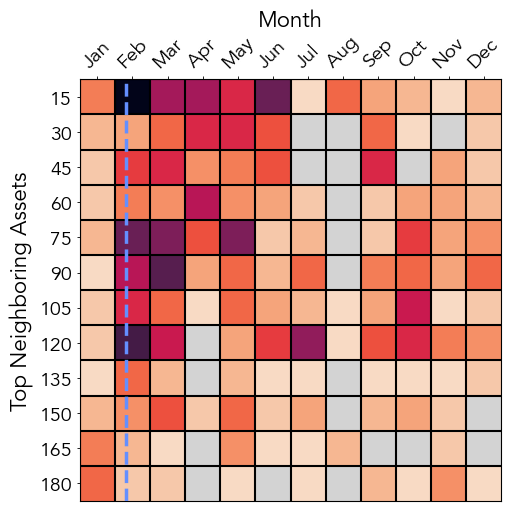

In [26]:
def _selected_scenarios_heatmap(_ax, T_tr_, d_h_, x_ts_, x_, idx_1_, t_ts, 
                                xlabel = True,
                                colorbar = True):

    N     = 12
    delta = 15

    d_      = _haversine_dist(x_, x_ts_)
    d_sort_ = np.sort(d_)[:-7]

    tops_      = [int((i + 1) * delta) for i in range(N)]
    intervals_ = [d_sort_[i - 1] for i in tops_]

    _date     = datetime.datetime.strptime(t_ts, "%Y-%m-%d %H:%M:%S")
    m_a       = _date.timetuple().tm_mon - 1
    day       = _date.timetuple().tm_mday - 1
    _, n_days = calendar.monthrange(_date.year, m_a + 1)

    m_tr_ = np.stack([datetime.datetime.strptime(T_tr_[i], "%Y-%m-%d %H:%M:%S").timetuple().tm_mon - 1
                      for i in range(T_tr_.shape[0])])
    print(m_a, day)
    K        = 0
    heatmap_ = np.zeros((N + 1, m_tr_.max() + 1))
    for d_h, m in zip(d_h_[idx_1_], m_tr_[idx_1_]):
        heatmap_[np.searchsorted(intervals_, d_h), m] += 1
        K += 1
        
    h_max = int(heatmap_.max())
    heatmap_[heatmap_ == 0.] = np.nan

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _cmap.set_bad(color= 'lightgray')  # RGBA: transparent
    
    month_ = ["Jan",
              "Feb",
              "Mar",
              "Apr",
              "May",
              "Jun",
              "Jul",
              "Aug",
              "Sep",
              "Oct",
              "Nov",
              "Dec"]

    print(K, month_[m_a])

    _ax.matshow(heatmap_[:-1, :], 
                cmap=_cmap, 
                vmin=0.0, 
                extent=[0, 12, N, 0])

    _ax.set_xticks(range(len(month_)), [] * len(month_))
    _ax.set_yticks(range(len(tops_)), [] * len(tops_))

    _ax.set_ylabel("Top Neighboring Assets", size=16)
    
    if xlabel:
        _ax.set_xlabel("Month", size=16)
    _ax.xaxis.set_label_position("top")

    _ax.set_xticks(np.arange(len(month_), dtype=int) + 0.5, month_,
                   rotation=45,
                   minor=True,
                   size=14)

    _ax.set_yticks(np.arange(len(tops_), dtype=int) + 0.5, tops_,
                   minor=True,
                   size=14)

    _ax.tick_params(which="major", 
                    bottom=False, 
                    left=False, 
                    top=False)
    
    _ax.tick_params(which="minor", 
                    bottom=False)
    
    _ax.grid(which="major", 
             color="k", 
             linestyle="-", 
             linewidth=1.5)

    _ax.axvline(m_a + day/n_days, 
                color=palette_.loc[0, "ibm"], 
                ls = '--',
                lw=2.5, 
                zorder=6)
    
    # if colorbar:
    #     cbar = _fig.colorbar(cm.ScalarMappable(cmap = _cmap),
    #                          cax = _ax.inset_axes([3.5, 13.125, 5., 0.5], transform = _ax.transData),
    #                          orientation="horizontal")
    
    #     cbar.set_ticks([0, 1], 
    #                    labels=[1, h_max], 
    #                    fontsize=14)
        
    #     cbar.ax.tick_params(length=0)
        
    #     cbar.ax.set_title("Neighbors", 
    #                       rotation = 0, 
    #                       fontsize = 14)


fig, _ax = plt.subplots(1, 1, 
                        figsize=(6.5, 5), 
                        layout="constrained")


_selected_scenarios_heatmap(_ax, T_tr_[:, t], _meta['d_h'], x_ts_, x_ts_[a, :], _meta['idx_1'], T_ts_[d, t], 
                            xlabel = True,
                            colorbar = True)

plt.savefig(path_to_images + f"/seasonly_neiboring_assets_{file_name}.png", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

In [ ]:
def _plot_scenario_filtering(_ax, d_h_, t_tr_, idx_1_, idx_2_, t_ts, Gamma, gamma, sigma):

    def __check_limit(x):
        if x > 365:
            x = x - 365
        if x < 1:
            x = x + 365
        return x

    _ax.scatter(t_tr_[idx_1_], d_h_[idx_1_],
                s=75,
                c="darkgray",
                lw=0.5,
                edgecolor="w",
                clip_on=False,
                zorder=4,
                label="Neighbors")

    _ax.scatter(t_tr_[idx_2_], d_h_[idx_2_],
                s=75,
                c=palette_.loc[3, "ibm"],
                lw=0.5,
                edgecolor="k",
                clip_on=False,
                zorder=5,
                label="Selected Neighbors")


    _ax.axvline(t_ts, 
                color=palette_.loc[0, "ibm"], 
                ls = '--',
                lw=2.5, 
                zorder=6)

    if Gamma != 0:  
        _ax.axvline(__check_limit(t_ts + gamma), 
                    c="k", 
                    ls='--', 
                    lw=1.5, 
                    zorder=10)
                    
        _ax.axvline(__check_limit(t_ts - gamma), 
                    c="k", 
                    ls='--', 
                    lw=1.5, 
                    zorder=10, 
                    label="Thresholds")

    
    if sigma != 0:
        _ax.axhline(sigma, 
                    c="k", 
                    ls='--', 
                    lw=1.5, 
                    zorder=10)

    #_ax.set_ylabel(r"$|| \mathbf{x}_\star - \mathbf{x}_n ||_\mathrm{H}$", size=14)
    #_ax.set_xlabel(r"$|| d_\star - d_n ||_\mathrm{p}$", size=16)
    _ax.set_xlabel(r"Year Day", size=16)
    _ax.set_ylabel(r"Distance (km)", size=16)

    _ax.tick_params(axis="both", 
                    labelsize=14)

    _ax.set_xlim(1, 365)


def _plot_dates_histogram(_ax, t_tr_, idx_1_, idx_2_, t_ts, Gamma, gamma):

    def __check_limit(x):
        if x > 365:
            x = x - 365
        if x < 1:
            x = x + 365
        return x

    _ax.hist(t_tr_[idx_1_], 
             bins=50, 
             range=(1, 365), 
             color="darkgray", 
             edgecolor="w", 
             lw=0.5)

    _ax.hist(t_tr_[idx_2_],
             bins=50,
             range=(1, 365),
             alpha=0.5,
             color=palette_.loc[3, "ibm"],
             edgecolor="k",
             lw=0.5)
    
    if Gamma != 0:  
        _ax.axvline(__check_limit(t_ts - gamma), 
                    c="k", 
                    ls="--", 
                    lw=1.5, 
                    zorder=2, 
                    label="d: day")
        
        _ax.axvline(__check_limit(t_ts + gamma), 
                    c="k", 
                    ls="--", 
                    lw=1.5, 
                    zorder=2, 
                    label="d: day")
        
    #_ax.set_xlabel(r"Year Day", size=16)
    _ax.set_ylabel(r"Neighbors", size=16)
    _ax.set_xlim(1, 365)
    _ax.tick_params(axis="both", labelsize=14)
    #_ax.legend(frameon=False, ncol=1, fontsize = 12)
    _ax.set_xticks([], [])

def _plot_distance_histogram(_ax, d_h_, idx_1_, idx_2_, d_max = 1200):

    d_max = d_h_.max()
    
    _ax.hist(d_h_[idx_1_], 
             bins=50, 
             range=(0, d_max), 
             color="darkgray", 
             edgecolor="w", 
             lw=0.5, 
             orientation="horizontal")
    
    _ax.hist(d_h_[idx_2_],
             bins=50,
             range=(0, d_max),    
             alpha=0.5,
             color=palette_.loc[3, "ibm"],
             edgecolor="k",
             lw=0.5, 
             orientation="horizontal")
    
    _ax.axhline(d_h_[idx_2_].max(), 
                c="k", 
                ls="--", 
                lw=1.5, 
                zorder=2, 
                label="r: max distance")
    
    #_ax.set_xlabel(r"Distance (km)", size=16)
    _ax.set_xlabel(r"Neighbors", size=16)
    #_ax.set_xlim(0, d_max)
    _ax.tick_params(axis="both", labelsize=14, rotation = 270)
    _ax.set_yticks([], [])

    #_ax.legend(frameon=False, ncol=1, fontsize = 12)

fig, _ax = plt.subplot_mosaic([["A", "."], 
                               ["B", "C"]],
                              figsize     = (7.5, 7.5),
                              layout      = "constrained",
                              gridspec_kw = dict(width_ratios  = (1, .25), 
                                                 height_ratios = (.25, 1)))


_plot_dates_histogram(_ax["A"], t_tr_, idx_1_, idx_2_, t_ts_[d], Gamma, gamma)
_plot_scenario_filtering(_ax["B"], d_h_, t_tr_, idx_1_, idx_2_, t_ts_[d], Gamma, gamma, sigma)
_plot_distance_histogram(_ax["C"], d_h_, idx_1_, idx_2_, d_max = 1200)

_ax["B"].legend(frameon=False, 
                ncol=3, 
                loc = (0., 1.), 
                fontsize = 12)

plt.savefig(path_to_images + f"/kNN_frequency_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

NameError: name 'd_f_' is not defined

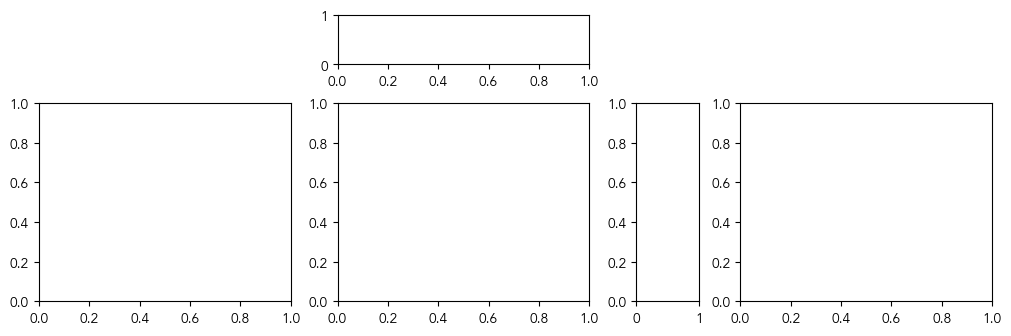

In [97]:
def _plot_density_threshold(_ax, d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

    _ax.plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)],
             c=palette_.loc[2, "ibm"],
             lw=3,
             label="f", 
             clip_on = False)

    _ax.plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)],
             c=palette_.loc[4, "ibm"],
             lw=3,
             label="e", 
             clip_on = False)

    _ax.axhline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                label=r"$\xi$", 
                zorder=10)
    
    _ax.set_ylabel(r"$\phi_{\varepsilon} \left( r_{\lambda} \left( \tau \right) \right)$", size=12)
    _ax.set_xlabel(r"$r_{\lambda} \left( \tau \right)$", size=12)
    
    _ax.tick_params(axis="both", 
                    labelsize=12)
    
    _ax.legend(frameon=False, 
               fontsize=12)

    _ax.set_ylim(0, 1)
    _ax.set_xlim(0, 1)

    
def _plot_fneighborhood(_ax, _ax_top, _ax_left, d_f_, d_e_, w_f_, w_e_, w_, idx_0_, xi):

    #c_ = [palette_.loc[2, "ibm"], palette_.loc[4, "ibm"]]

    _ax.tick_params(axis="y", 
                    labelleft=False)

    _ax.scatter(w_f_, w_e_, 
                color="gray", 
                s=0.25, 
                zorder=1, 
                clip_on = False)

    _ax.scatter(w_f_[idx_0_], w_e_[idx_0_], 
                c=palette_.loc[0, "ibm"],
                s=0.25, 
                zorder=2, 
                clip_on = False)

    _ax.axhline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                label=r"$\xi$", 
                zorder=10)

    _ax.axvline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                label=r"$\xi$", 
                zorder=10)

    _ax.set_ylabel(r"$\phi_{\varepsilon_e} \left( r_{\lambda_e} \left( \tau \right) \right)$", size=12)
    _ax.set_xlabel(r"$\phi_{\varepsilon_f} \left( r_{\lambda_f} \left( \tau \right)  \right)$", size=12)
    _ax.tick_params(axis="both", labelsize=12)

    _ax.set_ylim(0, 1)
    _ax.set_xlim(0, 1)

    _ax_top.hist(w_f_, 
                  bins=50, 
                  color="gray", 
                  density=True)

    # _ax["c"].tick_params(axis="x", 
    #                      labelbottom=False)
    
    _ax_top.tick_params(axis="both", 
                         labelsize=12)
    
    _ax_top.set_xlim(0, 1)

    _ax_left.hist(w_e_, 
                  bins=50, 
                  color="gray", 
                  density=True, 
                  orientation="horizontal")
    
    _ax_left.set_ylim(0, 1)

    _ax_left.tick_params(axis="both", 
                         labelsize=12)

def _plot_selection(_ax, d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

    _ax.scatter(w_f_, w_e_, 
                c="gray", 
                s=10, 
                alpha=1.0,
                lw=0.25, 
                ec="k", 
                label="Scenario", 
                clip_on = True)

    _ax.scatter(w_f_[idx_0_], w_e_[idx_0_],
                c=palette_.loc[0, "ibm"],
                s=10,
                alpha=1.0,
                lw=0.25,
                ec="k",
                label="Neighbor",
                clip_on = False)

    _ax.scatter(w_f_[idx_1_], w_e_[idx_1_],
                c=palette_.loc[3, "ibm"],
                s=10,
                lw=0.25,
                ec="k",
                alpha=1.0,
                label="Selected neighbor", 
                clip_on = False)

    _ax.axline((1, 1), 
               slope=1, 
               lw=1, 
               c="k")
    
    _ax.set_ylabel(r"$\phi_{\varepsilon_e} \left( r_{\lambda_e} \left( \tau \right) \right)$", size=12)
    _ax.set_xlabel(r"$\phi_{\varepsilon_f} \left( r_{\lambda_f} \left( \tau \right) \right)$", size=12)
    
    _ax.tick_params(axis="both", 
                    labelsize=12)
    
    _ax.set_xlim(xi, 1)
    _ax.set_ylim(xi, 1)
    
    _ax.axhline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                zorder=10)
    
    _ax.axvline(xi, 
                ls="--", 
                color="k", 
                lw=1.0, 
                zorder=10)
    
    _ax.legend(frameon=False, 
               fontsize=12, 
               ncol=1, 
               loc=(1., 0.))

  
fig, _ax = plt.subplot_mosaic([[".", ".", "e", ".", ".", "."],
                               ["A", "A", "B", "f", "C", "C"],
                               ["A", "A", "B", "f", "C", "C"]],
                               figsize     = (10, 3.25),
                               layout      = "constrained",
                               gridspec_kw = dict(width_ratios  = (2, 2, 4, 1, 2, 2), 
                                                  height_ratios = (1, 2, 2)))

# for label, ax in _ax.items():
#     if label.isupper():
#         ax.text(0.0, 1.0, label, 
#                 transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
#                 fontsize  = 22, 
#                 weight    = "bold",
#                 va        = 'bottom',
#                 family    = 'Arial')
    
_plot_density_threshold(_ax["A"], d_f_, d_e_, w_f_, w_e_, w_, idx_1_, idx_2_, idx_4_, xi)

_plot_fneighborhood(_ax["B"], _ax["e"], _ax["f"], d_f_, d_e_, w_f_, w_e_, w_, idx_1_, xi)

_plot_selection(_ax["C"], d_f_, d_e_, w_f_, w_e_, w_, idx_1_, idx_2_, idx_4_, xi)

plt.savefig(path_to_images + f"/fneighbor_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

NameError: name 'w_' is not defined

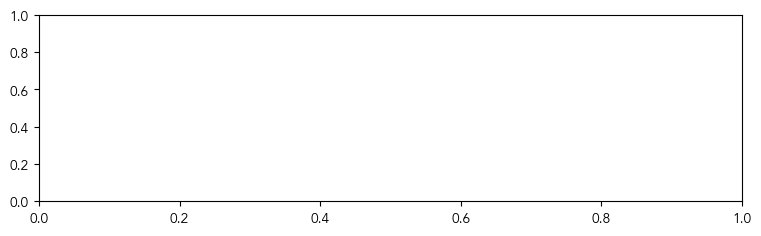

In [96]:
def _plot_forecasts(_ax, palette_, E_tr_, f_, e_, f_hat_, w_, idx_, dx_, dt_, t, 
                    legend = False):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    z_   = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]

    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0, 1)

    _ax.plot(tau_, 100.0 * f_,
             c=palette_.loc[0, "ibm"],
             clip_on=False,
             zorder=10,
             #label="CF (ac)",
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_,
             c=palette_.loc[0, "ibm"],
             clip_on=False,
             zorder=10,
             lw=2,
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             clip_on=False, 
             lw=2, 
             zorder=9, 
             #label="CF (fc)", 
             c="k")

    _ax.plot([], [], 
             label=r"$E_{\star} \left([\tau, s]\right)$", 
             c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_, 100 * E_tr_[i, :], 
                 c=_cmap(_norm(z_[i])), 
                 lw=0.75, 
                 zorder=8)

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.25,
                     zorder=1)

    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                zorder=11)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)

    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", 
                    labelsize=12)

    if legend:
        _ax.legend(frameon=False, 
                   fontsize=12, 
                   ncol=1)
    
def _plot_neighbors(_ax, palette_, F_tr_, f_, e_, f_hat_, w_, idx_, dx_, dt_, t, 
                   legend = False):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    z_   = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]

    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1.)

    _ax.plot(tau_, 100.0 * f_, 
             c=palette_.loc[0, "ibm"], 
             zorder=10, 
             #label="CF (ac)", 
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_, 
             c=palette_.loc[0, "ibm"], 
             zorder=10, 
             lw=2, 
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             lw=2, 
             zorder=9, 
             #label="CF (fc)", 
             c="k")

    _ax.plot([], [], 
             label=r"$\mathcal{F}_{\star} \left([\tau, s] \right)$", 
             c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_, 100 * F_tr_[i, :], 
                 c=_cmap(_norm(z_[i])), 
                 lw=0.75, 
                 zorder=8)

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.25,
                     zorder=1)

    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                zorder=11)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    _ax.set_ylim(0.0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", 
                    labelsize=12)

    if legend:
        _ax.legend(frameon=False, 
                   fontsize=12, 
                   ncol=1)

def _plot_updates(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, idx_, dx_, dt_, t,
                 legend = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    z_   = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    w_selected_ = w_[idx_]
    idx_w_ = np.argsort(w_selected_)
    print(w_selected_[idx_w_])
    print(w_selected_[idx_w_].shape, M_.shape)

    idx_   = idx_[idx_w_]
    
    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1)

    _ax.plot([], [], 
             label=r"$\hat{\mu}_i(s)$", 
             c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_[t:], 100 * M_[j, :],
                 c=_cmap(_norm(z_[i])), 
                 lw=0.75, 
                 zorder=8)

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375,
                     zorder=1)

    _ax.plot(tau_, 100.0 * f_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             label="CF (ac)",
             clip_on=False,
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             lw=2,
             clip_on=False,
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             lw=2, 
             zorder=9, 
             label="CF (fc)", 
             clip_on=False, 
             c="k")
    
    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                label="Event (update)", 
                zorder=8)
    
    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    
    _ax.tick_params(axis="both", 
                    labelsize=12)

    if legend:
        _ax.legend(frameon=False, 
                   fontsize=12, 
                   ncol=1)

    cbar = _fig.colorbar(cm.ScalarMappable(_norm, _cmap),
                         cax=_ax.inset_axes([150, 75, 150, 5], transform=_ax.transData),
                         orientation="horizontal",
                         extend="both")

    cbar.set_ticks([0, 1], 
                   labels=["low", "high"], 
                   size=12)
    
    cbar.ax.tick_params(length=0)
    
    cbar.ax.set_title("Similarity", 
                      rotation=0, 
                      size=12)

# fig, _ax = plt.subplots(1, 1, 
#                         figsize=(7.5, 2.25), 
#                         layout="constrained")

# _plot_forecasts(_ax, palette_, E_tr_, f_, e_, f_hat_, w_, idx_4_, dx_, dt_, t,
#                legend = True)

# plt.savefig(path_to_images + f"/day-ahead_neighbors_{file_name}.pdf", 
#             bbox_inches="tight", 
#             dpi=600)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_neighbors(_ax, palette_, F_tr_, f_, e_, f_hat_, w_, idx_4_, dx_, dt_, t, 
               legend = True)

plt.savefig(path_to_images + f"/partial_neighbors_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

# fig, _ax = plt.subplots(1, 1, 
#                         figsize=(7.5, 2.25), 
#                         layout="constrained")

# _plot_updates(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, idx_4_, dx_, dt_, t, 
#              legend = False)

# plt.savefig(path_to_images + f"/dynamic_update_neighbors_{file_name}.pdf", 
#             bbox_inches="tight", 
#             dpi=600)

# plt.show()

In [ ]:
def _plot_histogram_cuts(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    x_ = np.linspace(0, 100, 1000)[:, np.newaxis]

    for cut, i in zip(cuts_, range(len(cuts_))):
        _KD = KernelDensity(bandwidth=_silverman_rule(100 * M_[:, cut]),
                            algorithm="auto",
                            kernel="gaussian").fit(100 * M_[:, cut][:, np.newaxis])

        _ax[i].axvline(100 * f_hat_[cut],
                       color=palette_.loc[0, "ibm"],
                       lw=1,
                       ls="--",
                       label="CF (ac)",
                       zorder=10)

        _ax[i].axvline(100 * e_[t + cut], 
                       color="k", 
                       lw=1, 
                       label="CF (fc)", 
                       zorder=10)

        _ax[i].hist(100 * M_[:, cut],
                    bins=20,
                    range=(0, 100),
                    density=True,
                    color=palette_.loc[3, "ibm"], clip_on = True,
                    zorder=8, 
                    edgecolor='w', 
                    linewidth=.5)

        _ax[i].plot(x_, np.exp(_KD.score_samples(x_)),
                    label="KDE (update)",
                    color=palette_.loc[1, "ibm"],
                    lw=1.5,
                    zorder=9)

        _ax[i].set_title(dx_[t:][cut], size=12)
        _ax[i].set_xlim(0, 100)
        _ax[i].set_ylim(0,)
        
        #_ax[i].set_xlabel("Capacity Factor (%)", size=12)
        
        _ax[i].tick_params(axis="both",
                           labelsize=12)

    _ax[0].set_ylabel("EDF", size=12)

    # _ax[-1].legend(frameon=False, 
    #                fontsize=12)


def _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_,
                          legend = True, colorbar = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    Z_ = []
    for i in range(M_.shape[1]):
        a_, b_ = np.histogram(100.0 * M_[:, i], 
                              bins=25, 
                              range=(0, 100), 
                              density=True)
        Z_.append(a_)

    Z_ = np.stack(Z_).T
    X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1]) / 2.0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _ax.pcolormesh(X_, Y_, Z_, cmap =_cmap)

    _ax.plot(dt_, 100 * e_, 
             c="k", 
             lw=2.0, 
             label="CF (forecast)", 
             clip_on=False)

    _ax.plot(tau_, 100 * f_,
             c=palette_.loc[0, "ibm"],
             clip_on=False,
             lw=2.0,
             label="CF (actual)")

    _ax.plot(s_, 100 * f_hat_, 
             c=palette_.loc[0, "ibm"], 
             clip_on=False, 
             lw=2.0, 
             ls="--")

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375)

    _ax.axvline(dt_[t], 
                color="k", 
                linewidth=0.75, 
                label="Event (update)")

    _ax.axvline(dt_[t], 
                color="k", 
                lw=0.75, 
                ls="--", 
                label="Detail")

    for cut in cuts_:
        _ax.axvline(dt_[t + cut], 
                    color="k", 
                    lw=0.75, 
                    ls="--")

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])

    if legend:
        _ax.legend(frameon=False, 
                   fontsize=12, 
                   ncol=1)

    if colorbar:
        cbar = fig.colorbar(cm.ScalarMappable(cmap=_cmap),
                            cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                            orientation="horizontal",
                            extend="max")
    
        cbar.set_ticks([0, 1], labels=["low", "high"], fontsize = 12)
        cbar.ax.tick_params(length=0)
    
        cbar.ax.set_title("EDF", rotation=0)

cuts_ = [8, 16, 32, 64, 128]

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

_plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + f"/EDF_heatmap_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

fig, _ax = plt.subplots(1, len(cuts_), 
                        figsize=(7.5, 1.75), 
                        sharey=True, 
                        layout="constrained")

_plot_histogram_cuts(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + f"/marginal_density_cutoffs_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

In [ ]:
def _plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, w_, dx_, dt_, t, legend = True):

    tau_ = dt_[:t]
    s_   = dt_[t:]

    idx_ = np.argsort(w_)
    _cmap = sns.color_palette("rocket", as_cmap=True)
    _norm = plt.Normalize(0., 1)

    _ax.plot([], [], 
             label=r"$\hat{\mu}_i(s)$", 
             c="orange")

    for i in range(idx_.shape[0]):
        _ax.plot(dt_[t:], 100 * M_[idx_[i], :],
                 c=_cmap(_norm(i/idx_.shape[0])), 
                 lw=0.75, 
                 zorder=8)
        
    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375,
                     zorder=1)

    _ax.plot(tau_, 100.0 * f_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             label="CF (ac)",
             clip_on=False,
             lw=2)

    _ax.plot(s_, 100.0 * f_hat_,
             c=palette_.loc[0, "ibm"],
             zorder=10,
             lw=2,
             clip_on=False,
             ls="--")

    _ax.plot(dt_, 100.0 * e_, 
             lw=2, 
             zorder=9, 
             label="CF (fc)", 
             clip_on=False, 
             c="k")

    _ax.axvline(dt_[t], 
                color="k", 
                lw=1.0, 
                label="Event (update)", 
                zorder=8)
    
    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    
    _ax.tick_params(axis="both", 
                    labelsize=12)
    
    if legend:
        _ax.legend(frameon=False, 
                   fontsize=12, 
                   ncol=1)

    cbar = _fig.colorbar(cm.ScalarMappable(_norm, _cmap),
                         cax=_ax.inset_axes([100, 75, 150, 5], transform=_ax.transData),
                         orientation="horizontal")

    cbar.set_ticks([0, 1], 
                   labels=[M_.shape[0], 1], 
                   size=12)
        
    cbar.ax.set_title("Ranking", 
                      rotation=0, 
                      size=12)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")


# Calculate functional depth ranking
depth = 'MBD'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

depth = 'DQ'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()


fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

depth = 'LD'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

depth = 'ED'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

depth = 'ID'
d_ = _fDepth(M_, depth, path_to_fDepth).to_numpy()[:, 0]

_plot_depth(_fig, _ax, palette_, M_, f_, e_, f_hat_, d_, dx_, dt_, t, 
            legend = False)

plt.savefig(path_to_images + f"/{depth}_ranking_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

NameError: name 'tau_' is not defined

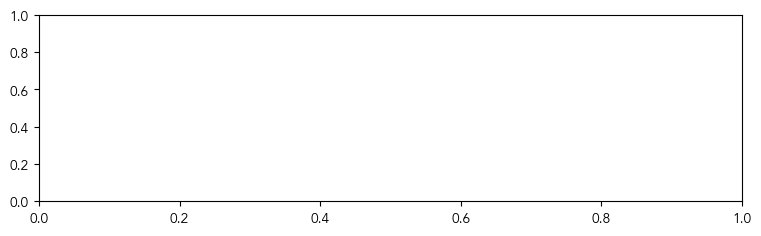

In [75]:
def _plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, tau_, s_, t, 
                  legend = True):

    s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)

    _ax.plot(dt_, 100 * e_, 
             c="k", 
             lw=2.0, 
             label="CF (fc)", 
             zorder = 8,
             clip_on=False)

    _ax.plot(tau_, 100 * f_, 
            c       = palette_.loc[0, "ibm"], 
            label   = "CF (ac)", 
            lw      = 2.0, 
            zorder = 8,
            clip_on = False)
    
    _ax.plot(s_, 100.0 * f_hat_, 
             c       = palette_.loc[0, "ibm"], 
             ls      = "--", 
             lw      = 2.0, 
             zorder = 7,
             clip_on = False)

    _ax.plot(s_, 100 * m_, 
            c       = palette_.loc[2, "ibm"], 
            label   = r"$\bar{\mu} (s)$", 
            lw      = 2.0, 
            zorder  = 9,
            clip_on = False)
    
    _ax.axvline(dt_[t], 
                color     = "k", 
                linewidth = 1.0, 
                label     = "Event (update)", 
                zorder    = 10)

    _cmap = sns.color_palette("gray", as_cmap=True)
    _norm = plt.Normalize(0, 1)
    
    for key, i in zip(_upper.keys(), range(len(_upper.keys()))):

        upper_ = np.concatenate([f_, _upper[key]], axis=0)[f_.shape[0] - 1:]
        lower_ = np.concatenate([f_, _lower[key]], axis=0)[f_.shape[0] - 1:]

        _ax.plot(s_p_, 100. * upper_, 
                 lw = 0.375, 
                 c  = "lightgray")
        
        _ax.plot(s_p_, 100. * lower_, 
                 lw = 0.375, 
                 c  = "lightgray")

        alpha = float(key)
        ci    = int((1. - alpha)*100)
        
        _ax.fill_between(s_p_, 100. * upper_, 100. * lower_,
                        color  = _cmap(_norm(0.9 - i*0.1)),
                        alpha  = 0.75,
                        label  = f"{ci}%",
                        zorder = 1)
            
    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color = "lightgray",
                     alpha = 0.25)

    _ax.set_xticks(dt_[24::24], dx_[24::24], rotation=0)
    
    if legend: 
        _ax.legend(frameon  = False, 
                   #loc      = (0.0125, 0.1),
                   fontsize = 12,
                   ncol     = 2)
        
    _ax.tick_params(axis      = "both", 
                    labelsize = 12)
    
    _ax.set_ylim(0, 100)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size = 14)
    
alpha_ = [0.1, 0.2, 0.3, 0.4]

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

# Calculate confidence intervals from functional depth metrics
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, tau_, s_, t, 
              legend = False)

# _ax.set_title('EDF', 
#               loc = 'left',
#               fontsize = 18, 
#               y = 0.8, 
#               x = 0.0125)

plt.savefig(path_to_images + f"/EDF_envelop_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

# Calculate confidence intervals from Directional Quantiles
depth = 'RT'
m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, depth, path_to_fDepth)

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, tau_, s_, t, 
              legend = False)

# _ax.set_title('Band Depth', 
#               loc = 'left', 
#               fontsize = 18, 
#               y = 0.8, 
#               x = 0.0125)

plt.savefig(path_to_images + f"/{depth}_envelop_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(7.5, 2.25), 
                        layout="constrained")

# Calculate confidence intervals from the functional depth metric
depth = 'DQ'
m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, depth, path_to_fDepth)

_plot_envelop(_ax, _upper, _lower, f_, e_, f_hat_, m_, dt_, dx_, tau_, s_, t, 
             legend = True)

# _ax.set_title('L-inf', 
#               loc = 'left',
#               fontsize = 18, 
#               y = 0.8, 
#               x = 0.0125)

plt.savefig(path_to_images + f"/{depth}_envelop_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

In [ ]:
# # import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.utils import resample
# from tqdm import tqdm

# alpha_ = [0.4, 0.5, 0.6, 0.7]

# # Compute central region
# def compute_central_band(X, depth, alpha=0.05):
#     n = X.shape[0]
#     k = int((1 - alpha) * n)
#     central_indices = np.argsort(depth)[-k:]
#     central_funcs = X[central_indices]
#     lower = np.min(central_funcs, axis=0)
#     upper = np.max(central_funcs, axis=0)
#     return lower, upper

# # Bootstrap calibration
# def _bootstrap_confidence_band(M_, alpha_, depth, path, B=200):
#     n, T = M_.shape
#     lower_band_samples = []
#     upper_band_samples = []

#     for b in tqdm(range(B), desc="Bootstrapping"):
#         resample_indices = np.random.choice(n, size=n, replace=True)
#         # Calculate confidence intervals from the functional depth metric
#         m_, _upper, _lower = _confidence_intervals_from_fDepth(M_[resample_indices], alpha_, depth, path)
#         #m_, _upper, _lower = _confidence_intervals_from_eCDF(m_, alpha_)

#         lower_band_samples.append(_lower[str(alpha_[0])])
#         upper_band_samples.append(_upper[str(alpha_[0])])

#     lower_band_samples = np.array(lower_band_samples)
#     upper_band_samples = np.array(upper_band_samples)
#     print(lower_band_samples.shape, upper_band_samples.shape)
#     # Pointwise percentile bands
#     #lower_final = np.percentile(lower_band_samples, alpha_[0] / 2 * 100, axis=0)
#     #upper_final = np.percentile(upper_band_samples, (1 - alpha_[0] / 2) * 100, axis=0)

#     lower_final = np.mean(lower_band_samples, axis=0)
#     upper_final = np.mean(upper_band_samples, axis=0)

#     return lower_final, upper_final

# # Derive confidence intervals from a functional depth metric
# def _confidence_intervals_from_fDepth(M_, alpha_, depth, path):

#     # Calculate functional depth ranking
#     D_ = _fDepth(M_, depth, path).to_numpy()[:, 0]

#     I_ = np.argsort(D_)[::-1]

#     _y_pred_upper = {}
#     _y_pred_lower = {}
#     for i in range(len(alpha_)):
#         scen_                         = M_[I_[:-int(M_.shape[0] * alpha_[i])],]
#         _y_pred_upper[f'{alpha_[i]}'] = np.max(scen_, axis = 0)
#         _y_pred_lower[f'{alpha_[i]}'] = np.min(scen_, axis = 0)

#     m_ = M_[I_[0],]

#     return m_, _y_pred_upper, _y_pred_lower

# def _eQuantile(_eCDF, q_):
#     """
#     Calculates quantiles from an ECDF.

#     Args:
#     _eCDF: function from statsmodels api
#     q_: A list or numpy array of quantiles to calculate (values between 0 and 1).

#     Returns:
#     _Q: A dictionary where keys are the input quantiles and values are the corresponding
#     Quantile values from the ECDF.
#     """

#     return np.array([_eCDF.x[np.searchsorted(_eCDF.y, q)] for q in q_])
    
# # Derive confidence intervals from a functional depth metric
# def _confidence_intervals_from_eCDF(M_, alpha_):    

#     _y_pred_upper = {}
#     _y_pred_lower = {}
#     for i in range(len(alpha_)):

#         _y_pred_lower[f'{alpha_[i]}'] = np.stack([_eQuantile(ECDF(M_[:, j]), [alpha_[i]/2.])
#                                                   for j in range(M_.shape[1])])[:, 0]
#         _y_pred_upper[f'{alpha_[i]}'] = np.stack([_eQuantile(ECDF(M_[:, j]), [1. - alpha_[i]/2.])
#                                                   for j in range(M_.shape[1])])[:, 0]

#     m_ = np.median(M_, axis = 0)

#     return m_, _y_pred_upper, _y_pred_lower
    
# alpha_ = [0.4]
# depth  = 'LD'
# print(M_.shape)

# t = np.linspace(0, M_.shape[1] - 1, M_.shape[1])

# # Calculate confidence intervals from the functional depth metric
# m_, _upper, _lower = _confidence_intervals_from_fDepth(M_, alpha_, depth, path_to_fDepth)
# #m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)
# lower_basic = _lower[str(alpha_[0])]
# upper_basic = _upper[str(alpha_[0])]

# for B in [25, 50, 100, 200, 400]:
#     # Step 3: Bootstrap calibrated band
#     lower_boot, upper_boot = _bootstrap_confidence_band(M_, alpha_, depth, path_to_fDepth, B = B)
    
#     plt.figure(figsize=(10, 6))
    
#     # Plot all curves
#     for func in M_:
#         plt.plot(t, func, color='gray', alpha=0.3)
    
#     # Plot central band
#     plt.fill_between(t, lower_basic, upper_basic, color='skyblue', alpha=0.5, label="Central Band (95%)")
    
#     # Plot bootstrap-calibrated band
#     plt.plot(t, lower_boot, color='blue', linestyle='--', label="Bootstrapped Lower")
#     plt.plot(t, upper_boot, color='blue', linestyle='--', label="Bootstrapped Upper")
    
#     plt.title("Functional Depth-Based 95% Confidence Band with Bootstrap")
#     plt.xlabel("t")
#     plt.ylabel("X(t)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


# Dynamic Forcasting Cone 

In [ ]:
def _empirical_interval_score(y_true, y_pred_lower, y_pred_upper, alpha):
    """
    Calculate the interval score for probabilistic forecasts with an interval [lower, upper].
    
    Parameters:
    - y_true: Observed (true) values
    - y_pred_upper: upper confidence interval for significance level alpha
    - y_pred_lower: low confidence interval for significance level alpha
    - alpha: Significance level (default 0.05 for 90% confidence interval)
    
    Returns:
    - interval_score: The calculated interval score
    """
        
    # Penalty for observation outside the lower bound
    penalty_lower = 2.*np.maximum(0, y_pred_lower - y_true)/alpha
    
    # Penalty for observation outside the upper bound
    penalty_upper = 2.*np.maximum(0, y_true - y_pred_upper)/alpha
    
    # Interval width penalty
    penalty_width = y_pred_upper - y_pred_lower
    
    # Total interval score
    return penalty_lower + penalty_upper + penalty_width

def _weighted_interval_score(y_true, y_pred, _y_pred_lower, _y_pred_upper, alpha_):
    """
    Calculate the interval score for probabilistic forecasts with an interval [lower, upper].
    
    Parameters:
    - y_true: Observed (true) values
    - _y_pred_lower: dictionary with upper confidence interval for all significance levels alpha
    - _y_pred_lower: dictionary with lower confidence interval for all significance levels alpha
    - alpha: all significance level alpha (default 0.05 for 90% confidence interval)

    Returns:
    - WIS: float, the Weighted Interval Score.
    """

    # Calculate the interval score
    w0  = 1/2.
    w_  = np.array(alpha_)/2.
    is_ = np.zeros((y_true.shape[0], w_.shape[0]))
    for i in range(len(alpha_)):
        is_[:, i] = _empirical_interval_score(y_true, 
                                              _y_pred_lower[f'{alpha_[i]}'],
                                              _y_pred_upper[f'{alpha_[i]}'], 
                                               alpha_[i])
    
    term0 = 1./(len(alpha_) + 1/2.)
    term1 = w0 * np.absolute(y_true - y_pred)

    for i in range(w_.shape[0]):
        is_[:, i] = w_[i] * is_[:, i]
    term2 = np.sum(is_, axis = 1)
        
    return term1 * (term1 + term2)

def _empirical_coverage_score(y_true, _lower, _upper, alpha_):
    """`
    Calculate the coverage score for probabilistic forecasts with an interval [lower, upper]
    
    Parameters:
    - y_: Observed (true) values
    - lower_: upper confidence bound
    - upper_: lower confidence dound
    
    Returns:
    - coverage_score: The calculated interval score
    """

    def _converage_score(y_true, lower_, upper_):
        coverage = 0
        for i in range(y_true.shape[0]): 
            if (y_true[i] < lower_[i]) or (y_true[i] > upper_[i]):
                coverage += 0
            else:
                coverage += 1
        return coverage / y_true.shape[0]


    cs_ = np.zeros((len(alpha_),))
    for i in range(len(alpha_)):
        cs_[i] = _converage_score(y_true, _lower[f'{alpha_[i]}'], _upper[f'{alpha_[i]}'])
    
    return cs_
    
# MBD_ = _modified_band_depth(M_)

alpha_ = [0.1, 0.2, 0.4]

# WIS_ = _weighted_interval_score(f_hat_, m_, _lower, _upper, alpha_)
# print(WIS_.mean())

# CS = _empirical_coverage_score(f_hat_, _lower, _upper, alpha_)
# print(CS)

# # Calculate confidence intervals from functional depth metrics
# m_, _upper, _lower = _confidence_intervals_from_MBD(M_, alpha_)
# print(m_.shape)

# # Calculate confidence intervals from functional depth metrics
# WIS_ = _weighted_interval_score(f_hat_, m_, _lower, _upper, alpha_)
# print(WIS_.mean())

# CS = _empirical_coverage_score(f_hat_, _lower, _upper, alpha_)
# print(CS)


In [ ]:
def _PIT_gaussian(y_true, forecast_mean, forecast_std, nbins=100):
    """
    Calculate the Probabilistic Integral Transform (PIT).

    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution

    Returns:
    - mean and std: The calculated PIT
    """

    u_samples = norm.cdf(y_true, loc=forecast_mean, scale=forecast_std)

    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize=(12.5, 2.5))
    plt.hist(
        u_samples,
        bins=nbins,
        density=True,
        alpha=0.7,
        color="blue",
        label="Transformed (U)",
    )

    plt.hlines(1, 0, 1, color="red", linestyle="--", label="Uniform distribution")

    plt.title("Probabilistic Integral Transform")
    plt.xlabel("U")
    plt.ylabel("PDF")
    plt.legend()


def _PIT(z_, nbins=100, file_name="unnamed.png"):
    """
    Calculate the Probabilistic Integral Transform (PIT).

    Parameters:
    - z_: CDF evaluations
    - nbins: number of bins in the histogram
    """

    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize=(5, 2.5))
    plt.hist(
        z_, bins=nbins, density=True, alpha=0.7, color="blue", label="Transformed (U)"
    )

    plt.hlines(1, 0, 1, color="red", linestyle="--", label="Uniform distribution")
    plt.ylim(
        0.0,
        2,
    )

    plt.title("Probabilistic Integral Transform")
    plt.xlabel("U")
    plt.ylabel("PDF")
    plt.legend()

    plt.savefig(path_to_images + r"/{}".format(file_name), bbox_inches="tight", dpi=300)


def _KS(z_, nbins=100):
    """
    Calculate the Kolmogorov–Smirnov (KS) statistic for a normal dist.

    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution

    Returns:
    - sup_ks: Kolmogorov–Smirnov statistic
    - avg_ks: Kolmogorov–Smirnov statistic but calculating RMSE instead of sup

    """

    # u_samples_  = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    hist_, bin_ = np.histogram(z_, nbins, density=True)
    bins_ = (bin_[:-1] + bin_[1:]) / 2.0
    # r_ = np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))

    plt.figure()
    plt.plot(np.cumsum(hist_))
    plt.plot(np.cumsum(np.ones(bins_.shape)))
    plt.show()

    # avg_ks = np.sqrt(np.mean((np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape)))**2))/hist_.shape[0]
    sup_ks = np.max(np.absolute(np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))))

    return sup_ks

In [ ]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 48
z_1_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_1_.append(_eCDF(f_ts_[i]))

In [ ]:
_PIT(
    np.stack(z_1_),
    nbins=10,
    file_name="{}_{}_{}-PIT-48.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_1_), nbins=100)

In [ ]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 24

z_2_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        #         f_fc_ts_ = F_fc_ts_[d, t:, a]
        #         f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if (_eCDF(f_ts_[i]) == 0.0) | (_eCDF(f_ts_[i]) == 1.0):
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_2_.append(_eCDF(f_ts_[i]))

In [ ]:
_PIT(
    np.stack(z_2_),
    nbins=10,
    file_name="{}_{}_{}-PIT-24.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_2_), nbins=100)

In [ ]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 12
z_3_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_3_.append(_eCDF(f_ts_[i]))

In [ ]:
_PIT(
    np.stack(z_3_),
    nbins=10,
    file_name="{}_{}_{}-PIT-12.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_3_), nbins=100)

In [ ]:
t = 144
forget_rate = 2
n_kNNs = 500

i = 60
z_4_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(36):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_4_.append(_eCDF(f_ts_[i]))

In [ ]:
_PIT(
    np.stack(z_4_),
    nbins=10,
    file_name="{}_{}_{}-PIT-60.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_4_), nbins=100)

In [ ]:
# # Forecast dynamic update based on distance
# def _ffc_predict(_model, f_, fc_):

#     F_ = _model['F_tr_']

#     # Smoothing observed mean and actuals
#     if (_model['smoothing'] == 1) | (_model['smoothing'] == 3):
#         F_, f_ = _smoothing(F_, f_, _model['lambda'])

#     # phi: importance weights based on time distance
#     phi_ = _exponential_decay_minus(f_.shape[0], _model['forget_rate'])

#     # plt.figure(figsize = (10, 2))
#     # plt.title('Forget Rate')
#     # plt.plot(phi_)
#     # plt.ylim(-0.1,1.1)
#     # plt.show()

#     # d: euclidian distance between samples weighted by importance weights (phi)
#     d_ = _dist(F_, f_, phi_/phi_.sum())
#     # w: normalized wieghts distance across observations based on RBF kernel distance
#     w_ = _kernel(d_, _model['length_scale'])

#     _model['weights'] = w_/w_.sum()

#     # Multivariate normal assumption
#     _model = _predictive_multivariate_normal_dist(_model, fc_)

#     return _model

# Multivariate normal forecast assumption
# def _predictive_multivariate_normal_dist(_model, fc_):

#     F_ = _model['F_ts_']
#     w_ = _model['weights']

#     # Mean function
#     f_hat_ = F_.T @ w_

#     # Regulate mean function
#     f_hat_ = _gen_constraint(f_hat_, _model['f_min'], _model['f_max'])

#     # Smoothing prediction: unobserved mean and actuals
#     if (_model['smoothing'] == 2) | (_model['smoothing'] == 3):
#         F_, f_hat_ = _smoothing(F_, f_hat_, _model['lambda'])

#     # Fuse day-ahead forecast with real-time forecast
#     mu_hat_ = _update_forecast(F_, f_hat_, fc_, _model['trust_rate'])

#     # Covariance function
#     F_hat_ = np.repeat(mu_hat_[:, np.newaxis], F_.shape[0], axis = 1).T
#     S_hat_ = (F_ - F_hat_).T @ np.diag(w_) @ (F_ - F_hat_)

#     # plt.figure(figsize = (10, 2))
#     # plt.plot(f_hat_, label = 'real-time (fc)')
#     # plt.plot(fc_, label = 'day-ahead (fc)')
#     # plt.plot(mu_hat_, label = 'update (fc)')
#     # plt.ylim(-0.1,)
#     # plt.legend()
#     # plt.show()

#     # Define probability dist
#     _N = multivariate_normal(mu_hat_, S_hat_, allow_singular = True)

#     _model['normal'] = {}
#     _model['normal']['mean']         = mu_hat_
#     _model['normal']['covariance']   = S_hat_
#     _model['normal']['distribution'] = _N

#     return _model.copy()

In [ ]:
# def _fneighborhood_v0(d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

#     #_cmap = plt.get_cmap('gnuplot')
#     _cmap = sns.color_palette("rocket_r", as_cmap = True)
#     _norm = plt.Normalize(w_.min(), w_.max())

#     fig, ax_ = plt.subplots(1, 3,
#                             figsize = (15, 5),
#                             layout  = 'constrained')

#     ax_[0].plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)],
#                 c     = palette_.loc[0, 'ibm'],
#                 label = 'f')
#     ax_[0].plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)],
#                 c     = palette_.loc[3, 'ibm'],
#                 label = 'e')

#     ax_[0].axhline(xi,
#                    color  = 'k',
#                    lw     = 1.,
#                    label  = r'$\xi$',
#                    zorder = 10)

#     ax_[0].set_ylabel(r'$\varphi_{\lambda} (r)$', size = 14)
#     ax_[0].set_xlabel(r'$r$', size = 14)

#     ax_[0].tick_params(axis      = 'both',
#                        labelsize = 12)

#     ax_[0].legend(frameon = False)
#     #plt.xlim(0, 1)
#     #plt.ylim(0, 1)

#     ax_[1].scatter(w_f_, w_e_,
#                    c     = _cmap(_norm(w_)),
#                    s     = 1.,
#                    alpha = 0.5)

#     ax_[1].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[1].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
#     ax_[1].tick_params(axis      = 'both',
#                        labelsize = 12)
#     #plt.xlim(0, 1)
#     #plt.ylim(0, 1)

# #     ax_[2].scatter(w_f_, w_e_, c = 'gray',
# #                                s = 1.,
# #                                alpha = .5)

# #     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_], c = palette_.loc[3, 'imb'],
# #                                                s = 1,
# #                                                alpha = .5)

# #     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
# #     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
# #     ax_[2].tick_params(axis = 'both', labelsize = 12)

#     ax_[2].scatter(w_f_, w_e_,
#                    c     = 'gray',
#                    s     = 15.,
#                    alpha = 1.,
#                    lw    = .125,
#                    ec    = 'k')

#     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_],
#                    c     = palette_.loc[0, 'ibm'],
#                    s     = 15,
#                    alpha = 1.,
#                    lw    = .125,
#                    ec    = 'k')

#     c_ = [palette_.loc[2, 'ibm'], palette_.loc[4, 'ibm']]
#     for i, j in zip(idx_2_, idx_0_[idx_2_]):
#         ax_[2].scatter(w_f_[i], w_e_[i],
#                        c     = c_[j],
#                        s     = 25,
#                        lw    = .25,
#                        ec    = 'k',
#                        alpha = 1.)

#     ax_[2].axline((1, 1), slope = 1,
#                           lw    = 1,
#                           c     = 'k')

#     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)

#     ax_[2].tick_params(axis      = 'both',
#                        labelsize = 12)

#     ax_[2].set_xlim(w_f_[idx_2_].min()*0.9985, w_f_[idx_2_].max()*1.0015)
#     ax_[2].set_ylim(w_e_[idx_2_].min()*0.9985, w_e_[idx_2_].max()*1.0015)

#     plt.savefig(path_to_images + r'/fneighbor.pdf',
#                 bbox_inches = 'tight',
#                 dpi         = 300)

#     plt.show()